In [18]:
from cleverhans.torch.attacks.noise import noise
from cleverhans.torch.attacks.hop_skip_jump_attack import hop_skip_jump_attack
from cleverhans.torch.attacks.spsa import spsa
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent

In [1]:
#https://github.com/nhamlv-55/CFI_NNs/blob/master/MNIST_toy/Experiment-Feb28-xujie-Copy1.ipynb

from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier, NewTinyCNN
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
import seaborn as sn
import pandas as pd

from absl import app, flags
from easydict import EasyDict
import torch.nn as nn

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)




%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
use_cuda = torch.cuda.is_available()
print(use_cuda)

lr = 0.01
log_interval = 100

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)
class Shift:
    def __init__(self, shift = 0):
        print("alive")
        self.shift = shift

    def __call__(self, arr):
        print("running")
        #print(arr)
        return arr
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])

def shift_and_roll(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:
    return torch.roll(arr, shifts = (x,y), dims = (0,1)) #indexing
def shift(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:

    pad = [0,0,0,0]
    x_start = 0
    x_end = 0
    y_start = 0
    y_end = 0
    if x >= 0:
        pad[0] = x
        x_start = 0
        x_end = 28
    else:
        pad[1] = abs(x)
        x_start = -28
         
         
        
         
    
    if y >= 0:
        pad[2] = y
        y_start = 0
        y_end = 28
    else:
        pad[3] = abs(y)
        y_start= -28
        print("ys is {}".format(y_start))
    

    padder = torch.nn.ZeroPad2d(tuple(pad))
  
    result = padder(arr)

    if y < 0:
        y_end = result.shape[0]
    if x < 0:
        x_end = result.shape[1]
    
    return result[y_start:y_end, x_start:x_end]

def noisify(arr : torch.Tensor , distribution : torch.distributions.Distribution) -> torch.Tensor: #randomly add noise
   
    #print(distribution.sample(arr.size()).shape\\)
    #print(torch.reshape(distribution.sample(arr.size()), (28,28)).shape)
   
    noise = torch.reshape(distribution.sample(arr.size()), (arr.shape))
    return arr + noise
transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
])


True


In [2]:
def transform_dataset(dataset):
    '''
    DO A STATE CHANGE
    '''
    shift_x = 1
    shift_y = 0
    mu = 1
    sigma = 1
    do_shift = False
    do_noisfy = True
    modification_string = "base"
    if do_shift:
        modification_string += " -shift {} {} - ".format(shift_x, shift_y)
    if do_noisfy:
        modification_string += " -noise added using gaussian using mean {} and stddev {}- ".format(mu, sigma)
    for i in range(dataset.data.shape[0]):
        if do_shift:
            dataset.data[i,:,:] = shift(dataset.data[i,:,:],shift_x, shift_y)
        
        if do_noisfy:
            gaussian = torch.distributions.Normal(loc = mu, scale = sigma)# loc = mu, scale = stddev

            dataset.data[i,:,:] = noisify(dataset.data[i,:,:], gaussian)
    return modification_string

## Train/Load model


In [3]:
def check_gradient(grad, label, last_sorted_grads, plot = False):
    logging.info("CHECKING GRADIENT FOR LABEL {}".format(label))
    sum_abs_grad = np.sum(abs(grad[label]), axis = 0)
    
    current_sorted_grad = (-sum_abs_grad).argsort()
    
#     if len(last_sorted_grads[label]) > 0:
#         for k in [100, 200, 300, 400]:
#             prev_top_k = set(last_sorted_grads[label][-1][:k])
#             current_top_k = set(current_sorted_grad[:k])
#             intersect = prev_top_k.intersection(current_top_k)
#             logging.info('k = {}. How many top Gradients are stable since last epoch?: {}'.format(k, len(intersect)))
        
    for k in [0, 9, 99, 199]:    
        logging.debug('{}th biggest gradient = {}'.format(k, np.sort(-sum_abs_grad)[k]))
    if plot:
        fig = plt.figure(figsize=(30, 1))
        plt.bar(range(sum_abs_grad.shape[0]), sum_abs_grad)
        plt.show()
        print(sum_abs_grad.max(), sum_abs_grad.argmax(), sum_abs_grad.min())

    return current_sorted_grad



#init stuffs
LOAD = True
# LOADPATH = 'FFN19-17-24'
# LOADPATH = 'FFN18_28_21'
LOADPATH = 'TinyCNN23-50-30'

LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('./data', train=True, download=False,
                          transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=False,
                          transform=transform)


#transform_dataset(dataset1)
#modification_string = transform_dataset(dataset2)
modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
model = TinyCNN().to(device)

if LOAD:
    model.load_state_dict(torch.load(LOADPATH))
else:

    epochs = 10
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    last_sorted_grads = defaultdict(list)
    
    all_rows = []
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.register_gradient()
        model.train()
        target_log  = None # need to record the label to match with the gradient later
        for data, target in train_loader:
            target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        CFI_utils.test(model, device, test_loader)
#         scheduler.step()
#         grad = CFI_utils.get_grad_each_label(model.gradient_log, 
#                                       target_log = target_log, 
# #                                       layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
#                                       layers = ['conv1', 'conv2','fc1', 'fc2'],
#                                       labels = range(10))
        torch.save(model.state_dict(), model.model_savename())
        
#         row_data = []
#         for label in range(10):
#             r = []
#             logging.info("After {} epoch:".format(epoch))
#             last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))
            
            
#             if epoch >= LAST_N_EPOCHS:
#                 for k in [100, 200, 300, 400]:
#                     all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
#                     intersect = set.intersection(*all_top_k)
#                     logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))

                    

with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        data_extend = data[None, :]
#         if int(torch.argmax(model.cpu()(data.cpu()), dim = 1)) == target:
        if int(torch.argmax(model.cuda()(data_extend.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
    modification_string += " -accuracy {}-".format( correct/total)
    print(modification_string)

 -accuracy 0.8374-


#### Compute all patterns in the training set, and put them into corresponding labels

In [4]:
class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self.label2idx = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        
        label2patterns = {}
        label2idx = {}
        for label in self._labels:
            patterns = []
            filter_ids = []
            
            for data, target in self._dataloader:
                
                flter = np.where(target == label)
                filter_ids.append(flter)
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            filter_ids = np.squeeze(np.concatenate(filter_ids, axis = 0))
            label2patterns[label] = patterns
            label2idx[label] = filter_ids
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns = dict(label2patterns)
        self.label2idx = dict(label2idx)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass
    
    

# layers = ['fc1', 'fc2', 'fc3', 'fc4']
layers = ['conv1', 'conv2','fc1', 'fc2']

labels = range(10)
K = 25
stable_loader = torch.utils.data.DataLoader(dataset1, **stable_kwargs)

all_patterns = Patterns(model = model,
                        dataloader = stable_loader,
                        labels = labels,
                        layers = layers)
all_test_patterns = Patterns(model = model,
                        dataloader = test_loader,
                        labels = labels,
                        layers = layers)



root - INFO - (5923, 7338)
root - INFO - (6742, 7338)
root - INFO - (5958, 7338)
root - INFO - (6131, 7338)
root - INFO - (5842, 7338)
root - INFO - (5421, 7338)
root - INFO - (5918, 7338)
root - INFO - (6265, 7338)
root - INFO - (5851, 7338)
root - INFO - (5949, 7338)
root - INFO - (980, 7338)
root - INFO - (1135, 7338)
root - INFO - (1032, 7338)
root - INFO - (1010, 7338)
root - INFO - (982, 7338)
root - INFO - (892, 7338)
root - INFO - (958, 7338)
root - INFO - (1028, 7338)
root - INFO - (974, 7338)
root - INFO - (1009, 7338)


In [5]:
#we can only study gradient if the model is trained
# FIXME: should save gradient into a pickle as well
if not LOAD:
    for K in [25, 50, 100]:
        print("K=", K)
        row = []
        row.append(str(K))
        for label in labels:
            #construct the stable gradients 
            all_top_k = [set(sorted_grad[:K]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
            intersect = set.intersection(*all_top_k)
            stable_grad = np.array(sorted(list(intersect)))
            print("There are {} stable grad in top K".format(len(stable_grad)))
            print(stable_grad)

            logging.info(all_patterns[label].shape)
            print("LABEL:", label)
            print("how many unique paths in the full pattern?", np.unique(all_patterns[label], axis = 0).shape)
            print("how many unique paths in the filtered pattern?", np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape)
            print("how many unique paths in the randomly filtered pattern?", 
                  np.unique(patterns[:, 
                                     np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape)
            row.append("|".join([str(len(stable_grad)),
                                 str(np.unique(all_patterns[label], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape[0])
                                ]))
        all_rows.append(",".join(row)+"\n")

    with open("gradient_exp_log_2.csv", "w") as f:
        f.write("K,"+",".join([str(l) for l in labels]) + "\n")
        f.writelines(all_rows)

In [6]:
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.bool_):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
    


all_stable_relus = []

all_alpha_patterns = {"model": LOADPATH}

write_log = True
if write_log:
    ReLU_exp_log = open("relu_exp_log{}.csv".format(datetime.now().strftime("%H-%M-%S")), "w")
    ReLU_exp_json = open("relu_exp_data{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")
    ReLU_exp_log.write("Epsilon,Label,NumStableReLU,NumUniqueAP,Alpha Pattern Cover\n")



# for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
epsilon_to_patterns = dict()
for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
    alpha_patterns = {}
    label_to_most_common_pattern = dict()
    for label in all_patterns.label2patterns:
#     for label in [0,2,8]:
        patterns = all_patterns.label2patterns[label]
        print(patterns.shape)

        occuring_patterns = patterns.tolist() #make patterns into list of lists first dim is each example, second dim is the pattern
        most_common_pattern = max(occuring_patterns, key =  lambda x :occuring_patterns.count(x)) #argmax the count of each pattern

        #print("most common pattern: {}".format(most_common_pattern) )
        
        pattern_indices = list(filter( lambda x : most_common_pattern[x] , range(len(most_common_pattern))   ))#get true indices     
        #print("pattern_indices: {}".format(pattern_indices))
        label_to_most_common_pattern[label] = (pattern_indices,most_common_pattern)
        relu_sum = np.sum(patterns, axis = 0).squeeze()
        
        print("threshold: ", epsilon*patterns.shape[0], (1-epsilon)*patterns.shape[0])
        
#         print("relu_sum, layer-1 ", relu_sum[:256])
#         print("relu_sum, layer-2 ", relu_sum[256:384])
#         print("relu_sum, layer-3 ", relu_sum[384:448])
        print("relu_sum, prediction", relu_sum[448:458])
#         print("relu_sum", relu_sum[-10:])
        
        non_active_neurons = np.where(relu_sum<=epsilon*patterns.shape[0])
        active_neurons = np.where(relu_sum>=(1-epsilon)*patterns.shape[0])
        print("non active neurons: ", non_active_neurons)
        print("active neurons: ", active_neurons)

        stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
                                     np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
                                    axis = 1
                                    ).squeeze()
        neuro_idx = patterns.shape[1] - 10 + label
        if neuro_idx not in stable_idx:
            print(f"WARN: neuro_idx = {neuro_idx} for label {label} is not stable, let's include it anyway")
            stable_idx = np.append(stable_idx, neuro_idx)
        stable_idx = sorted(stable_idx) #sort the indices of the stable ReLUs. 
        unique_patterns, freq = np.unique(patterns[:, stable_idx ], axis = 0, return_counts=True)
        alpha_p = unique_patterns[np.argmax(freq)]
        print("unique patterns:", unique_patterns)
        print()
        print("Label is ", label)
        print("Stable ReLUs", stable_idx)
        print("how many unique paths in the filtered pattern?", unique_patterns.shape)
        print("their freq\n", freq, freq.shape)
#         print("most prominent pattern", np.argmax(freq), alpha_p)
#         print("alpha_p is ", alpha_p)


        assert(len(stable_idx) == alpha_p.shape[-1])
        assert(freq.shape[0]==unique_patterns.shape[0])
#         alpha_patterns[label] = (stable_idx, tuple(alpha_p))
#         alpha_patterns[label] = {"stable_idx": stable_idx,
#                                 "alpha_pattern": alpha_p,
#                                 "alpha_pattern_coverage": freq.max()/freq.sum(),
#                                 "pattern_frequency": freq}
        alpha_patterns[label] = {"stable_idx": stable_idx,
                                 "active_neurons": active_neurons[0],
                                 "non_active_neurons": non_active_neurons[0],
                                "alpha_pattern": alpha_p,
                                "alpha_pattern_coverage": freq.max()/freq.sum(),
                                "pattern_frequency": freq}
    
#         print("pattern frequency:", freq)
        print("primary pattern coverage: ", freq.max()/freq.sum(),)

        if write_log:
            ReLU_exp_log.write("{},{},{},{},{}\n".format(epsilon, label, len(stable_idx), unique_patterns.shape[0], freq.max()/freq.sum()))
    all_alpha_patterns[epsilon] = alpha_patterns
    epsilon_to_patterns[epsilon] = label_to_most_common_pattern
json.dump(epsilon_to_patterns, open("most_common_patterns{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")) 
    
if write_log:
    ReLU_exp_log.close()
    json.dump(all_alpha_patterns, fp = ReLU_exp_json, indent=2, cls=NpEncoder)
    ReLU_exp_json.close()

(5923, 7338)
threshold:  0.5923 5922.4077
relu_sum, prediction [4723 3982 3627 4047 4928 5562 5822 5879 5884 5835]
non active neurons:  (array([ 676,  677,  678,  679,  680,  682,  684,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  727,  728,  729,  730,
        754,  780,  781,  806,  807,  832,  833,  858,  910,  936,  988,
       1014, 1040, 1066, 1092, 1118, 1196, 1222, 1223, 1248, 1249, 1273,
       1274, 1275, 1276, 1299, 1300, 1301, 1302, 1303, 1324, 1325, 1326,
       1327, 1328, 1329, 1330, 1331, 1332, 1344, 1345, 1346, 1347, 1348,
       1349, 1350, 1351, 2028, 2029, 2030, 2031, 2032, 2035, 2036, 2037,
       2038, 2039, 2044, 2045, 2047, 2048, 2049, 2050, 2051, 2052, 2053,
       2054, 2055, 2056, 2057, 2078, 2079, 2080, 2081, 2105, 2106, 2107,
       2130, 2131, 2132, 2133, 2134, 2158, 2159, 2183, 2184, 2185, 2186,
       2210, 2211, 2235, 2236, 2238, 2261, 2262, 2263, 2288, 2313, 2339,
       2340, 2341, 2342, 2391, 2392, 2393, 2417, 2418, 2419,

unique patterns: [[ True  True  True ...  True  True False]
 [ True  True  True ...  True  True  True]]

Label is  1
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 70, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 102, 103, 104, 107, 129, 130, 131, 155, 156, 157, 181, 182, 207, 208, 209, 210, 233, 236, 237, 259, 262, 263, 286, 288, 312, 313, 338, 339, 364, 365, 390, 396, 415, 416, 419, 441, 442, 444, 468, 470, 471, 472, 520, 521, 522, 572, 598, 599, 600, 601, 624, 625, 626, 627, 650, 651, 652, 653, 654, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 725, 726, 727, 729, 753, 754, 779, 780, 805, 806, 831, 832, 857, 858, 859, 883, 884, 936, 962, 988, 1014, 1015, 1039, 1040, 1041, 1065, 1066, 

threshold:  0.6131 6130.3869
relu_sum, prediction [6006 5940 5873 5817 5769 5782 5831 5928 5955 5829]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  695,  696,
        697,  698,  699,  700,  701,  702,  703,  704,  725,  726,  727,
        728,  729,  751,  752,  753,  754,  778,  779,  805,  831,  857,
        883,  962,  988, 1065, 1091, 1117, 1143, 1169, 1195, 1221, 1247,
       1273, 1299, 1300, 1323, 1324, 1325, 1326, 1327, 1328, 1349, 1350,
       1351, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
       2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056,
       2057, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2103, 2104, 2105,
       2106, 2107, 2129, 2130, 2131, 2132, 2155, 2156, 2157, 2181, 2182,
       2183, 2185, 2207, 2208, 2209, 2233, 2235, 2259, 2261, 2285, 2287,
       2313, 2339, 2365, 2416, 2417, 2442, 2468, 2469, 2494, 2495, 2520,
       2546, 2547, 2548, 2571, 2572, 2573, 2598, 2623, 2624, 2625, 2626,


unique patterns: [[ True  True  True ...  True  True False]
 [ True  True  True ...  True  True  True]]

Label is  4
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 76, 77, 78, 79, 80, 81, 82, 84, 85, 104, 105, 106, 107, 130, 131, 132, 133, 156, 157, 158, 182, 183, 184, 208, 209, 234, 235, 236, 260, 261, 286, 312, 338, 339, 340, 364, 365, 366, 390, 391, 416, 417, 442, 443, 468, 469, 494, 495, 520, 521, 546, 547, 548, 572, 573, 574, 575, 576, 598, 599, 600, 601, 602, 624, 625, 626, 627, 628, 650, 651, 652, 653, 654, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 699, 700, 701, 702, 703, 704, 705, 706, 727, 728, 729, 754, 755, 780, 806, 832, 1170, 1196, 1197, 1222, 1223, 1224, 1248, 1249, 1250, 1274, 1275, 1276, 1300, 1301, 1302, 1325, 1326, 1327, 1328, 1350, 1351, 1

threshold:  0.5918 5917.4082
relu_sum, prediction [5800 5644 5356 5069 4842 4752 4736 4818 5083 5398]
non active neurons:  (array([ 676,  677,  678,  679,  703,  728,  754,  755,  780,  781,  806,
        807,  832,  833,  858,  859,  884,  885,  910,  911,  936,  937,
        962,  963,  988,  989, 1014, 1015, 1040, 1041, 1066, 1067, 1092,
       1118, 1144, 1145, 1170, 1171, 1196, 1197, 1198, 1222, 1223, 1224,
       1225, 1248, 1249, 1250, 1251, 1252, 1271, 1272, 1273, 1274, 1275,
       1276, 1277, 1278, 1279, 1280, 1297, 1298, 1299, 1300, 1301, 1302,
       1303, 1304, 1305, 1306, 1307, 1308, 1309, 1320, 1321, 1322, 1323,
       1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334,
       1335, 1336, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347,
       1348, 1349, 1350, 1351, 2028, 2030, 2053, 2054, 2078, 2080, 2081,
       2082, 2105, 2106, 2131, 2132, 2158, 2184, 2186, 2210, 2211, 2212,
       2236, 2237, 2238, 2262, 2263, 2264, 2288, 2289, 2290, 2314, 2315,


threshold:  0.6265000000000001 6264.3735
relu_sum, prediction [6131 6081 6042 6016 6037 6071 6068 5730 4676 3144]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  733,
        734,  735,  736,  744,  745,  746,  748,  750,  751,  752,  753,
        754,  777,  778,  779,  805, 1066, 1092, 1144, 1170, 1171, 1196,
       1197, 1222, 1223, 1248, 1274, 1300, 1301, 1325, 1326, 1327, 1328,
       1350, 1351, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 

threshold:  0.5851000000000001 5850.4149
relu_sum, prediction [5794 5667 5378 4820 4055 3429 3555 4076 4240 4088]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  693,  695,  696,  697,  698,  699,
        700,  701,  702,  703,  704,  705,  706,  707,  708,  727,  728,
        729,  730,  731,  732,  754,  755,  756,  780,  781,  806,  807,
        832,  858,  884,  910,  936,  962,  988,  989, 1014, 1015, 1040,
       1066, 1092, 1093, 1118, 1144, 1170, 1196, 1222, 1248, 1249, 1273,
       1274, 1275, 1276, 1298, 1299, 1300, 1301, 1302, 1303, 1324, 1325,
       1326, 1327, 1328, 1329, 1330, 1347, 1350, 1351, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053,
       2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2106, 2107, 2108, 2109, 

threshold:  0.5949 5948.4051
relu_sum, prediction [5831 5659 5329 4849 4367 4289 4557 4910 4643 3502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  719,  721,
        722,  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,
        733,  734,  735,  736,  749,  750,  751,  752,  753,  754,  755,
        756,  757,  758,  759,  777,  778,  779,  780,  781,  782,  783,
        805,  806,  807,  808,  832,  833,  858,  884,  910, 1014, 1040,
       1066, 1118, 1144, 1170, 1171, 1196, 1222, 1248, 1249, 1274, 1275,
       1300, 1301, 1326, 1327, 1351, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044,
       2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055,


threshold:  2.9615 5920.038500000001
relu_sum, prediction [4723 3982 3627 4047 4928 5562 5822 5879 5884 5835]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        688,  690,  691,  692,  693,  694,  695,  696,  697,  698,  699,
        700,  701,  702,  703,  704,  705,  706,  726,  727,  728,  729,
        730,  731,  753,  754,  755,  756,  757,  779,  780,  781,  805,
        806,  807,  832,  833,  858,  859,  884,  885,  910,  911,  936,
        937,  962,  963,  988,  989, 1014, 1015, 1040, 1041, 1066, 1092,
       1118, 1144, 1170, 1195, 1196, 1221, 1222, 1223, 1247, 1248, 1249,
       1273, 1274, 1275, 1276, 1299, 1300, 1301, 1302, 1303, 1322, 1323,
       1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1342,
       1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050

threshold:  3.371 6738.629000000001
relu_sum, prediction [6736 6732 6731 6725 6681 6383 5079 2882 1700 3529]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        693,  694,  695,  696,  697,  698,  699,  700,  701,  702,  703,
        704,  705,  706,  707,  708,  709,  710,  724,  725,  726,  727,
        728,  729,  730,  731,  732,  733,  753,  754,  755,  756,  757,
        779,  780,  781,  805,  806,  807,  808,  809,  831,  832,  833,
        834,  857,  858,  859,  860,  861,  883,  884,  885,  886,  887,
        908,  909,  910,  911,  912,  913,  935,  936,  937,  938,  960,
        962,  963,  985,  986,  987,  988,  989,  990, 1011, 1012, 1013,
       1014, 1015, 1016, 1017, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1091, 1092, 1093,
       1094, 1095, 1117, 1118, 1119, 1120, 1121, 1144, 1145, 1146, 1170,
       1171, 1196, 1197, 1222, 1223, 1248, 1249, 1272, 1273, 1274,

threshold:  2.979 5955.021000000001
relu_sum, prediction [5454 5210 5049 5003 5015 4942 4805 4628 4533 4502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  697,  698,  699,  700,  701,  702,
        703,  704,  725,  726,  727,  728,  729,  752,  753,  754,  755,
        778,  779,  780,  805,  806,  857,  858,  883,  884,  910,  936,
        962,  963,  988, 1014, 1040, 1222, 1248, 1249, 1274, 1275, 1276,
       1300, 1301, 1302, 1303, 1326, 1327, 1328, 1329, 1330, 1331, 1332,
       1333, 1334, 1335, 1347, 1348, 1349, 1350, 1351, 2028, 2029, 2030,
       2031, 2032, 2033, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055,
       2056, 2057, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2103,
       2104, 2105, 2106, 2107, 2108, 2129, 2130, 2131, 2132, 2133, 2134,
       2155, 2156, 2157, 2158, 2159, 2160, 2182, 2183, 2184, 2185, 2186,
       2207, 2208, 2209, 2210, 2211, 2234, 2235, 2236, 2237, 2261, 2262,
       2263, 2287, 2288, 2289, 2314, 2315, 2340, 2341, 2366, 2367,

threshold:  3.0655 6127.9345
relu_sum, prediction [6006 5940 5873 5817 5769 5782 5831 5928 5955 5829]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  724,  725,  726,
        727,  728,  729,  751,  752,  753,  754,  778,  779,  780,  805,
        806,  831,  857,  883,  908,  909,  910,  934,  935,  936,  960,
        961,  962,  986,  987,  988, 1013, 1014, 1039, 1065, 1091, 1117,
       1143, 1169, 1195, 1221, 1246, 1247, 1272, 1273, 1274, 1297, 1298,
       1299, 1300, 1301, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329,
       1347, 1348, 1349, 1350, 1351, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044,
       2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055,
       2056, 2057, 2058, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082,


threshold:  2.9210000000000003 5839.079000000001
relu_sum, prediction [5043 4575 4217 4001 3958 4147 4455 4576 4249 3408]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  692,  694,  696,  697,  698,  699,  700,  701,  702,  703,
        704,  705,  706,  707,  708,  709,  726,  727,  728,  729,  730,
        754,  755,  780,  806,  832,  858,  884,  962,  988, 1014, 1040,
       1066, 1092, 1118, 1144, 1170, 1171, 1195, 1196, 1197, 1222, 1223,
       1224, 1225, 1248, 1249, 1250, 1274, 1275, 1276, 1299, 1300, 1301,
       1302, 1303, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1350,
       1351, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
       2038, 2039, 2040, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049,
       2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060,
       2061, 2078, 2079, 2080, 2081, 2082, 2083, 2105, 2106, 2107, 2108,
       2131, 2132, 2133, 2134, 2158, 2159, 2160, 2184

threshold:  2.7105 5418.2895
relu_sum, prediction [5204 5166 5103 4998 5007 5057 5111 5086 4920 4606]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  696,  697,  698,  699,  700,  701,  702,  703,
        704,  705,  706,  707,  708,  709,  727,  728,  729,  730,  731,
        754,  755,  756,  780,  781,  806,  807,  832,  833,  858,  859,
        884,  885,  910,  911,  936,  962,  988, 1014, 1015, 1040, 1066,
       1092, 1118, 1170, 1196, 1222, 1248, 1249, 1273, 1274, 1275, 1299,
       1300, 1301, 1302, 1303, 1325, 1326, 1327, 1328, 1329, 1330, 1350,
       1351, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
       2038, 2039, 2040, 2041, 2042, 2044, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2078, 2079, 2080, 2081, 2082, 2083, 2084, 2106, 2107, 2108, 2109,
       2132, 2133, 2134, 2135, 2158, 2159, 2160, 2161, 2162, 2184, 2185,


threshold:  2.959 5915.041
relu_sum, prediction [5800 5644 5356 5069 4842 4752 4736 4818 5083 5398]
non active neurons:  (array([ 676,  677,  678,  679,  701,  702,  703,  704,  727,  728,  729,
        754,  755,  780,  781,  806,  807,  832,  833,  858,  859,  884,
        885,  910,  911,  936,  937,  962,  963,  988,  989, 1014, 1015,
       1040, 1041, 1066, 1067, 1092, 1093, 1118, 1119, 1144, 1145, 1170,
       1171, 1196, 1197, 1198, 1222, 1223, 1224, 1225, 1247, 1248, 1249,
       1250, 1251, 1252, 1253, 1271, 1272, 1273, 1274, 1275, 1276, 1277,
       1278, 1279, 1280, 1281, 1296, 1297, 1298, 1299, 1300, 1301, 1302,
       1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1318, 1319, 1320,
       1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331,
       1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342,
       1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 2028, 2029,
       2030, 2032, 2052, 2053, 2054, 2055, 2056, 2057, 2078, 2079, 2080,
  

threshold:  3.1325000000000003 6261.8675
relu_sum, prediction [6131 6081 6042 6016 6037 6071 6068 5730 4676 3144]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  737,  738,  739,  740,  741,
        742,  743,  744,  745,  746,  747,  748,  749,  750,  751,  752,
        753,  754,  755,  756,  775,  776,  777,  778,  779,  780,  804,
        805,  831, 1040, 1066, 1092, 1118, 1119, 1144, 1145, 1169, 1170,
       1171, 1172, 1195, 1196, 1197, 1221, 1222, 1223, 1247, 1248, 1249,
       1273, 1274, 1298, 1299, 1300, 1301, 1323, 1324, 1325, 1326, 1327,
       1328, 1349, 1350, 1351, 2028, 2029, 2030, 2031, 2032, 

unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  7
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 181, 182, 184, 208, 209, 234, 260, 286, 311, 312, 338, 339, 36

threshold:  2.9255 5848.074500000001
relu_sum, prediction [5794 5667 5378 4820 4055 3429 3555 4076 4240 4088]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  725,  726,  727,  728,  729,  730,  731,  732,  754,
        755,  756,  757,  780,  781,  782,  806,  807,  832,  858,  884,
        910,  936,  962,  988,  989, 1014, 1015, 1040, 1041, 1042, 1066,
       1067, 1092, 1093, 1118, 1119, 1144, 1145, 1169, 1170, 1171, 1195,
       1196, 1197, 1221, 1222, 1223, 1247, 1248, 1249, 1273, 1274, 1275,
       1276, 1298, 1299, 1300, 1301, 1302, 1303, 1324, 1325, 1326, 1327,
       1328, 1329, 1330, 1331, 1347, 1348, 1349, 1350, 1351, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050

threshold:  2.9745 5946.025500000001
relu_sum, prediction [5831 5659 5329 4849 4367 4289 4557 4910 4643 3502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  747,  748,  749,  750,  751,
        752,  753,  754,  755,  756,  757,  758,  759,  760,  777,  778,
        779,  780,  781,  782,  783,  784,  804,  805,  806,  807,  808,
        831,  832,  833,  858,  859,  884,  910,  936,  962,  987,  988,
       1013, 1014, 1039, 1040, 1065, 1066, 1091, 1092, 1118, 1144, 1145,
       1170, 1171, 1196, 1197, 1222, 1223, 1224, 1248, 1249, 1274, 1275,
       1299, 1300, 1301, 1325, 1326, 1327, 1328, 1350, 1351, 2028

unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True  True False]]

Label is  9
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 181, 182, 183, 184, 185, 186, 187, 208, 209, 210, 211, 234, 235, 236, 260, 261, 26

threshold:  5.923 5917.077
relu_sum, prediction [4723 3982 3627 4047 4928 5562 5822 5879 5884 5835]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  725,  726,  727,  728,  729,  730,  731,  752,  753,  754,
        755,  756,  757,  779,  780,  781,  782,  805,  806,  807,  832,
        833,  858,  859,  884,  885,  910,  911,  936,  937,  962,  963,
        988,  989, 1014, 1015, 1040, 1041, 1066, 1067, 1092, 1118, 1144,
       1169, 1170, 1195, 1196, 1221, 1222, 1223, 1247, 1248, 1249, 1272,
       1273, 1274, 1275, 1276, 1296, 1297, 1298, 1299, 1300, 1301, 1302,
       1303, 1304, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329,
       1330, 1331, 1332, 1333, 1334, 1340, 1341, 1342, 1343, 1344, 1345,
       1346, 1347, 1348, 1349, 1350, 1351, 2028, 2029, 2030, 2031, 2032,
  

unique patterns: [[ True  True  True ...  True False  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  0
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 129, 130, 131, 132, 133, 134, 135, 136, 155, 156, 157, 158, 159, 182, 183, 184, 185, 208, 209, 210, 211, 212, 233, 234, 235, 236, 237, 238, 259, 260, 261, 262, 263, 286, 287, 288, 289, 312, 313, 314, 315, 338, 339, 340, 341, 364, 365, 366, 367, 390, 391, 392, 393, 416, 417, 418, 419, 442, 

threshold:  6.742 6735.258
relu_sum, prediction [6736 6732 6731 6725 6681 6383 5079 2882 1700 3529]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  692,  693,  694,  695,  696,  697,  698,  699,  700,  701,
        702,  703,  704,  705,  706,  707,  708,  709,  710,  724,  725,
        726,  727,  728,  729,  730,  731,  732,  733,  734,  752,  753,
        754,  755,  756,  757,  758,  759,  779,  780,  781,  782,  783,
        784,  805,  806,  807,  808,  809,  831,  832,  833,  834,  835,
        857,  858,  859,  860,  861,  883,  884,  885,  886,  887,  908,
        909,  910,  911,  912,  913,  914,  934,  935,  936,  937,  938,
        939,  959,  960,  961,  962,  963,  964,  965,  966,  967,  985,
        986,  987,  988,  989,  990,  991,  992,  993, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1036, 1037, 1038, 1039,
       1040, 1041, 1042, 1043, 1044, 1045, 1063, 1064, 1065, 1066, 1067,
  

threshold:  5.958 5952.042
relu_sum, prediction [5454 5210 5049 5003 5015 4942 4805 4628 4533 4502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  696,  697,  698,  699,  700,  701,
        702,  703,  704,  705,  725,  726,  727,  728,  729,  730,  752,
        753,  754,  755,  778,  779,  780,  781,  805,  806,  831,  832,
        857,  858,  883,  884,  909,  910,  936,  937,  962,  963,  988,
        989, 1014, 1040, 1066, 1092, 1222, 1248, 1249, 1274, 1275, 1276,
       1299, 1300, 1301, 1302, 1303, 1304, 1324, 1325, 1326, 1327, 1328,
       1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1346,
       1347, 1348, 1349, 1350, 1351, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056,
       2057, 2058, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2102,
       2103, 2104, 2105, 2106, 2107, 2108, 2129, 2130, 2131, 2132, 2133,
       2134, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2181, 2182, 2183,
  

threshold:  6.131 6124.869
relu_sum, prediction [6006 5940 5873 5817 5769 5782 5831 5928 5955 5829]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  723,  724,
        725,  726,  727,  728,  729,  730,  751,  752,  753,  754,  755,
        778,  779,  780,  804,  805,  806,  831,  832,  857,  883,  884,
        908,  909,  910,  934,  935,  936,  960,  961,  962,  963,  986,
        987,  988,  989, 1012, 1013, 1014, 1039, 1065, 1091, 1117, 1143,
       1169, 1195, 1220, 1221, 1246, 1247, 1248, 1271, 1272, 1273, 1274,
       1297, 1298, 1299, 1300, 1301, 1302, 1322, 1323, 1324, 1325, 1326,
       1327, 1328, 1329, 1346, 1347, 1348, 1349, 1350, 1351, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
  

threshold:  5.8420000000000005 5836.158
relu_sum, prediction [5043 4575 4217 4001 3958 4147 4455 4576 4249 3408]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  726,  727,  728,  729,  730,  731,  753,  754,  755,  780,
        781,  806,  832,  858,  884,  910,  936,  962,  988, 1014, 1040,
       1066, 1092, 1118, 1144, 1145, 1169, 1170, 1171, 1195, 1196, 1197,
       1198, 1221, 1222, 1223, 1224, 1225, 1248, 1249, 1250, 1251, 1273,
       1274, 1275, 1276, 1277, 1299, 1300, 1301, 1302, 1303, 1304, 1324,
       1325, 1326, 1327, 1328, 1329, 1330, 1331, 1349, 1350, 1351, 2028,
       2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039,
       2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050,
       2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2

threshold:  5.421 5415.579
relu_sum, prediction [5204 5166 5103 4998 5007 5057 5111 5086 4920 4606]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  695,  696,  697,  698,  699,  700,
        701,  702,  703,  704,  705,  706,  707,  708,  709,  726,  727,
        728,  729,  730,  731,  754,  755,  756,  757,  780,  781,  782,
        806,  807,  832,  833,  858,  859,  884,  885,  910,  911,  936,
        937,  962,  988,  989, 1014, 1015, 1039, 1040, 1065, 1066, 1091,
       1092, 1118, 1144, 1170, 1195, 1196, 1221, 1222, 1223, 1247, 1248,
       1249, 1273, 1274, 1275, 1276, 1298, 1299, 1300, 1301, 1302, 1303,
       1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1349, 1350, 1351,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049,
       2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060,
  

threshold:  5.918 5912.082
relu_sum, prediction [5800 5644 5356 5069 4842 4752 4736 4818 5083 5398]
non active neurons:  (array([ 676,  677,  678,  679,  701,  702,  703,  704,  705,  727,  728,
        729,  730,  754,  755,  756,  780,  781,  782,  806,  807,  808,
        832,  833,  834,  858,  859,  860,  884,  885,  886,  910,  911,
        936,  937,  962,  963,  988,  989,  990, 1014, 1015, 1016, 1040,
       1041, 1066, 1067, 1092, 1093, 1118, 1119, 1144, 1145, 1170, 1171,
       1172, 1196, 1197, 1198, 1199, 1221, 1222, 1223, 1224, 1225, 1226,
       1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1271, 1272, 1273,
       1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1295, 1296, 1297,
       1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308,
       1309, 1310, 1311, 1313, 1317, 1318, 1319, 1320, 1321, 1322, 1323,
       1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334,
       1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345,
  

unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  6
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 49, 50, 51, 52, 53, 54, 55, 57, 58, 77, 78, 79, 80, 81, 104, 105, 106, 107, 130, 131, 132, 133, 156, 157, 158, 159, 182, 183, 184, 185, 208, 209, 210, 211, 212, 234, 235, 236, 237, 260, 261, 262, 263, 264, 286, 287, 288, 289, 290, 312, 313, 314, 315, 316, 338, 339, 340, 341, 342, 364, 365, 366, 367, 368, 390, 391, 392, 393, 394, 416, 417, 418, 419, 420, 442, 443, 444, 445, 446, 468, 469, 470, 471, 472, 494, 495, 496, 497, 498, 520, 521, 522, 523, 524, 546, 547, 548, 549, 550, 571, 572, 573, 574, 575, 576, 577, 595, 596, 597, 598, 599, 600, 601, 602, 603, 6

threshold:  6.265000000000001 6258.735
relu_sum, prediction [6131 6081 6042 6016 6037 6071 6068 5730 4676 3144]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  737,  738,  739,  740,  741,
        742,  743,  744,  745,  746,  747,  748,  749,  750,  751,  752,
        753,  754,  755,  756,  774,  775,  776,  777,  778,  779,  780,
        781,  804,  805,  831,  987, 1040, 1066, 1092, 1093, 1117, 1118,
       1119, 1143, 1144, 1145, 1169, 1170, 1171, 1172, 1195, 1196, 1197,
       1198, 1220, 1221, 1222, 1223, 1245, 1246, 1247, 1248, 1249, 1272,
       1273, 1274, 1275, 1297, 1298, 1299, 1300, 1301, 1323, 13

unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  7
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 181, 182, 183, 184, 208, 209, 234, 260, 286, 31

threshold:  5.851 5845.149
relu_sum, prediction [5794 5667 5378 4820 4055 3429 3555 4076 4240 4088]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  724,  725,  726,  727,  728,  729,  730,  731,
        732,  733,  753,  754,  755,  756,  757,  758,  780,  781,  782,
        806,  807,  832,  833,  858,  884,  910,  936,  937,  962,  963,
        988,  989,  990, 1014, 1015, 1016, 1040, 1041, 1042, 1066, 1067,
       1092, 1093, 1117, 1118, 1119, 1143, 1144, 1145, 1169, 1170, 1171,
       1195, 1196, 1197, 1221, 1222, 1223, 1247, 1248, 1249, 1272, 1273,
       1274, 1275, 1276, 1298, 1299, 1300, 1301, 1302, 1303, 1323, 1324,
       1325, 1326, 1327, 1328, 1329, 1330, 1331, 1346, 1347, 1348, 1349,
       1350, 1351, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
  

unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  8
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 130, 131, 132, 133, 134, 135, 136, 156, 157, 158, 159, 160, 161, 182, 183, 184, 185, 186, 187, 208, 209, 210, 211, 212, 234, 235, 236, 237, 260, 261, 262, 263, 286, 287, 288, 289, 312, 313, 314, 315, 338, 339, 340, 341, 342, 364, 365, 366, 367, 368, 390, 391, 392, 393, 394,

threshold:  5.949 5943.051
relu_sum, prediction [5831 5659 5329 4849 4367 4289 4557 4910 4643 3502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  737,  747,  748,  749,  750,
        751,  752,  753,  754,  755,  756,  757,  758,  759,  760,  776,
        777,  778,  779,  780,  781,  782,  783,  784,  803,  804,  805,
        806,  807,  808,  809,  831,  832,  833,  834,  857,  858,  859,
        883,  884,  885,  910,  935,  936,  961,  962,  987,  988, 1013,
       1014, 1039, 1040, 1065, 1066, 1091, 1092, 1093, 1117, 1118, 1119,
       1143, 1144, 1145, 1169, 1170, 1171, 1196, 1197, 1198, 1222, 1223,
  

threshold:  29.615000000000002 5893.385
relu_sum, prediction [4723 3982 3627 4047 4928 5562 5822 5879 5884 5835]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  751,  752,  753,  754,  755,  756,  757,
        758,  778,  779,  780,  781,  782,  783,  804,  805,  806,  807,
        808,  809,  831,  832,  833,  834,  857,  858,  859,  860,  883,
        884,  885,  886,  909,  910,  911,  935,  936,  937,  961,  962,
        963,  988,  989, 1014, 1015, 1040, 1041, 1066, 1067, 1092, 1093,
       1117, 1118, 1119, 1143, 1144, 1145, 1169, 1170, 1171, 1195, 1196,
       1197, 1220, 1221, 1222, 1223, 1246, 1247, 1248, 1249, 1250, 1270,
       1271, 1272, 1273, 1274, 1275, 1276, 1277, 1295, 1296, 1

threshold:  33.71 6708.29
relu_sum, prediction [6736 6732 6731 6725 6681 6383 5079 2882 1700 3529]
non active neurons:  (array([ 676,  677,  678, ..., 7316, 7323, 7328], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7319, 7322, 7336], dtype=int64),)
WARN: neuro_idx = 7329 for label 1 is not stable, let's include it anyway
unique patterns: [[ True  True  True ... False  True  True]
 [ True  True  True ... False  True  True]
 [ True  True  True ... False  True  True]
 ...
 [ True  True  True ... False  True  True]
 [ True  True  True ... False  True  True]
 [ True  True  True ... False  True  True]]

Label is  1
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9

threshold:  29.79 5928.21
relu_sum, prediction [5454 5210 5049 5003 5015 4942 4805 4628 4533 4502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  694,  695,  696,
        697,  698,  699,  700,  701,  702,  703,  704,  705,  706,  724,
        725,  726,  727,  728,  729,  730,  731,  751,  752,  753,  754,
        755,  756,  778,  779,  780,  781,  804,  805,  806,  807,  830,
        831,  832,  833,  856,  857,  858,  859,  882,  883,  884,  885,
        908,  909,  910,  911,  934,  935,  936,  937,  961,  962,  963,
        964,  988,  989,  990, 1014, 1015, 1040, 1066, 1092, 1118, 1144,
       1170, 1196, 1222, 1248, 1249, 1273, 1274, 1275, 1276, 1277, 1299,
       1300, 1301, 1302, 1303, 1304, 1305, 1323, 1324, 1325, 1326, 1327,
       1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338,
       1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349,
       1350, 1351, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
   

threshold:  30.655 6100.345
relu_sum, prediction [6006 5940 5873 5817 5769 5782 5831 5928 5955 5829]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        722,  723,  724,  725,  726,  727,  728,  729,  730,  731,  750,
        751,  752,  753,  754,  755,  777,  778,  779,  780,  804,  805,
        806,  830,  831,  832,  856,  857,  858,  882,  883,  884,  908,
        909,  910,  934,  935,  936,  937,  959,  960,  961,  962,  963,
        964,  985,  986,  987,  988,  989,  990, 1012, 1013, 1014, 1015,
       1038, 1039, 1040, 1064, 1065, 1066, 1091, 1117, 1143, 1168, 1169,
       1194, 1195, 1220, 1221, 1222, 1245, 1246, 1247, 1248, 1271, 1272,
       1273, 1274, 1275, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1320,
       1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331,
 

threshold:  29.21 5812.79
relu_sum, prediction [5043 4575 4217 4001 3958 4147 4455 4576 4249 3408]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  724,  725,  726,  727,
        728,  729,  730,  731,  732,  733,  753,  754,  755,  756,  757,
        779,  780,  781,  782,  806,  807,  832,  833,  858,  859,  884,
        885,  910,  911,  935,  936,  961,  962,  963,  987,  988,  989,
       1014, 1040, 1066, 1067, 1092, 1093, 1117, 1118, 1119, 1143, 1144,
       1145, 1146, 1168, 1169, 1170, 1171, 1172, 1173, 1194, 1195, 1196,
       1197, 1198, 1199, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1246,
       1247, 1248, 1249, 1250, 1251, 1252, 1272, 1273, 1274, 1275, 1276,
       1277, 1278, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1323,
   

threshold:  27.105 5393.8949999999995
relu_sum, prediction [5204 5166 5103 4998 5007 5057 5111 5086 4920 4606]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  725,  726,  727,  728,  729,  730,  731,
        732,  733,  753,  754,  755,  756,  757,  758,  780,  781,  782,
        783,  806,  807,  808,  832,  833,  834,  858,  859,  860,  884,
        885,  886,  910,  911,  936,  937,  962,  963,  988,  989, 1013,
       1014, 1015, 1016, 1039, 1040, 1041, 1065, 1066, 1067, 1091, 1092,
       1093, 1117, 1118, 1119, 1143, 1144, 1145, 1169, 1170, 1171, 1195,
       1196, 1197, 1221, 1222, 1223, 1246, 1247, 1248, 1249, 1250, 1272,
       1273, 1274, 1275, 1276, 1277, 1297, 1298, 1299, 1300, 1301, 1302,
       1303, 1304, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 132

threshold:  29.59 5888.41
relu_sum, prediction [5800 5644 5356 5069 4842 4752 4736 4818 5083 5398]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  699,  700,  701,  702,  703,
        704,  705,  706,  726,  727,  728,  729,  730,  731,  732,  753,
        754,  755,  756,  757,  779,  780,  781,  782,  783,  805,  806,
        807,  808,  809,  831,  832,  833,  834,  835,  856,  857,  858,
        859,  860,  882,  883,  884,  885,  886,  909,  910,  911,  912,
        935,  936,  937,  938,  961,  962,  963,  964,  988,  989,  990,
       1014, 1015, 1016, 1040, 1041, 1042, 1066, 1067, 1068, 1092, 1093,
       1094, 1118, 1119, 1120, 1144, 1145, 1146, 1169, 1170, 1171, 1172,
       1195, 1196, 1197, 1198, 1199, 1220, 1221, 1222, 1223, 1224, 1225,
       1226, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254,
       1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279,
       1280, 1281, 1282, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300,
   

threshold:  31.325 6233.675
relu_sum, prediction [6131 6081 6042 6016 6037 6071 6068 5730 4676 3144]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  737,  738,  739,  740,  741,
        742,  743,  744,  745,  746,  747,  748,  749,  750,  751,  752,
        753,  754,  755,  756,  757,  758,  759,  772,  773,  774,  775,
        776,  777,  778,  779,  780,  781,  782,  803,  804,  805,  806,
        830,  831,  857,  883,  909,  935,  961,  987,  988, 1013, 1014,
       1039, 1040, 1041, 1065, 1066, 1067, 1091, 1092, 1093, 1094, 1117,
       1118, 1119, 1120, 1142, 1143, 1144, 1145, 1146, 1147, 1167, 1168,
 

threshold:  29.255 5821.745
relu_sum, prediction [5794 5667 5378 4820 4055 3429 3555 4076 4240 4088]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  719,  720,  721,  722,
        723,  724,  725,  726,  727,  728,  729,  730,  731,  732,  733,
        734,  752,  753,  754,  755,  756,  757,  758,  779,  780,  781,
        782,  783,  806,  807,  808,  832,  833,  834,  858,  859,  884,
        885,  910,  911,  936,  937,  962,  963,  964,  988,  989,  990,
       1014, 1015, 1016, 1017, 1039, 1040, 1041, 1042, 1043, 1065, 1066,
       1067, 1068, 1091, 1092, 1093, 1094, 1117, 1118, 1119, 1120, 1143,
       1144, 1145, 1169, 1170, 1171, 1194, 1195, 1196, 1197, 1198, 1220,
       1221, 1222, 1223, 1224, 1246, 1247, 1248, 1249, 1250, 1271, 1272,
 

threshold:  29.745 5919.255
relu_sum, prediction [5831 5659 5329 4849 4367 4289 4557 4910 4643 3502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  737,  738,  739,  740,  741,
        742,  743,  744,  745,  746,  747,  748,  749,  750,  751,  752,
        753,  754,  755,  756,  757,  758,  759,  760,  761,  762,  775,
        776,  777,  778,  779,  780,  781,  782,  783,  784,  785,  803,
        804,  805,  806,  807,  808,  809,  810,  830,  831,  832,  833,
        834,  835,  856,  857,  858,  859,  860,  883,  884,  885,  909,
        910,  911,  935,  936,  937,  960,  961,  962,  986,  987,  988,
 

threshold:  59.230000000000004 5863.7699999999995
relu_sum, prediction [4723 3982 3627 4047 4928 5562 5822 5879 5884 5835]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  722,  723,  724,  725,  726,  727,  728,
        729,  730,  731,  732,  733,  734,  751,  752,  753,  754,  755,
        756,  757,  758,  759,  778,  779,  780,  781,  782,  783,  784,
        804,  805,  806,  807,  808,  809,  831,  832,  833,  834,  835,
        857,  858,  859,  860,  883,  884,  885,  886,  909,  910,  911,
        912,  935,  936,  937,  961,  962,  963,  987,  988,  989, 1013,
       1014, 1015, 1039, 1040, 1041, 1065, 1066, 1067, 1091, 1092, 1093,
       1117, 1118, 1119, 1143, 1144, 1145, 1169, 1170, 1171, 1194, 1195,
       1196, 1197, 1220, 1221, 1222, 1223, 1224, 124

threshold:  67.42 6674.58
relu_sum, prediction [6736 6732 6731 6725 6681 6383 5079 2882 1700 3529]
non active neurons:  (array([ 676,  677,  678, ..., 7323, 7328, 7332], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7322, 7329, 7336], dtype=int64),)
unique patterns: [[ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]
 ...
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]]

Label is  1
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 

threshold:  59.58 5898.42
relu_sum, prediction [5454 5210 5049 5003 5015 4942 4805 4628 4533 4502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  693,  694,
        695,  696,  697,  698,  699,  700,  701,  702,  703,  704,  705,
        706,  707,  723,  724,  725,  726,  727,  728,  729,  730,  731,
        751,  752,  753,  754,  755,  756,  777,  778,  779,  780,  781,
        782,  804,  805,  806,  807,  830,  831,  832,  833,  856,  857,
        858,  859,  882,  883,  884,  885,  908,  909,  910,  911,  912,
        934,  935,  936,  937,  938,  960,  961,  962,  963,  964,  987,
        988,  989,  990, 1014, 1015, 1016, 1040, 1041, 1066, 1092, 1118,
       1144, 1170, 1196, 1222, 1223, 1248, 1249, 1250, 1273, 1274, 1275,
       1276, 1277, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306,
       1307, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328,
       1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339,
   

threshold:  61.31 6069.69
relu_sum, prediction [6006 5940 5873 5817 5769 5782 5831 5928 5955 5829]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  750,  751,  752,  753,  754,  755,  756,  777,  778,  779,
        780,  781,  803,  804,  805,  806,  807,  830,  831,  832,  856,
        857,  858,  882,  883,  884,  885,  908,  909,  910,  911,  933,
        934,  935,  936,  937,  938,  959,  960,  961,  962,  963,  964,
        985,  986,  987,  988,  989,  990,  991, 1011, 1012, 1013, 1014,
       1015, 1016, 1038, 1039, 1040, 1041, 1064, 1065, 1066, 1090, 1091,
       1092, 1116, 1117, 1118, 1142, 1143, 1168, 1169, 1194, 1195, 1196,
       1220, 1221, 1222, 1245, 1246, 1247, 1248, 1249, 1270, 1271, 1272,
   

threshold:  58.42 5783.58
relu_sum, prediction [5043 4575 4217 4001 3958 4147 4455 4576 4249 3408]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        722,  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,
        733,  734,  752,  753,  754,  755,  756,  757,  779,  780,  781,
        782,  806,  807,  808,  832,  833,  858,  859,  884,  885,  909,
        910,  911,  935,  936,  937,  961,  962,  963,  987,  988,  989,
       1013, 1014, 1015, 1039, 1040, 1041, 1065, 1066, 1067, 1091, 1092,
       1093, 1117, 1118, 1119, 1120, 1142, 1143, 1144, 1145, 1146, 1168,
       1169, 1170, 1171, 1172, 1173, 1194, 1195, 1196, 1197, 1198, 1199,
       1200, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1246, 1247, 1248,
   

threshold:  54.21 5366.79
relu_sum, prediction [5204 5166 5103 4998 5007 5057 5111 5086 4920 4606]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  723,  724,  725,  726,  727,
        728,  729,  730,  731,  732,  733,  734,  753,  754,  755,  756,
        757,  758,  780,  781,  782,  783,  806,  807,  808,  809,  832,
        833,  834,  858,  859,  860,  884,  885,  886,  910,  911,  912,
        936,  937,  938,  962,  963,  964,  987,  988,  989,  990, 1012,
       1013, 1014, 1015, 1016, 1038, 1039, 1040, 1041, 1042, 1064, 1065,
       1066, 1067, 1091, 1092, 1093, 1117, 1118, 1119, 1143, 1144, 1145,
       1169, 1170, 1171, 1194, 1195, 1196, 1197, 1220, 1221, 1222, 1223,
       1224, 1246, 1247, 1248, 1249, 1250, 1271, 1272, 1273, 1274, 1275,
   

threshold:  59.18 5858.82
relu_sum, prediction [5800 5644 5356 5069 4842 4752 4736 4818 5083 5398]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  699,  700,  701,  702,
        703,  704,  705,  706,  707,  726,  727,  728,  729,  730,  731,
        732,  752,  753,  754,  755,  756,  757,  758,  779,  780,  781,
        782,  783,  804,  805,  806,  807,  808,  809,  830,  831,  832,
        833,  834,  835,  855,  856,  857,  858,  859,  860,  861,  882,
        883,  884,  885,  886,  887,  908,  909,  910,  911,  912,  935,
        936,  937,  938,  961,  962,  963,  964,  987,  988,  989,  990,
       1014, 1015, 1016, 1040, 1041, 1042, 1066, 1067, 1068, 1092, 1093,
       1094, 1118, 1119, 1120, 1144, 1145, 1146, 1169, 1170, 1171, 1172,
       1173, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1219, 1220, 1221,
       1222, 1223, 1224, 1225, 1226, 1227, 1244, 1245, 1246, 1247, 1248,
       1249, 1250, 1251, 1252, 1253, 1254, 1269, 1270, 1271, 1272, 1273,
   

threshold:  62.65 6202.35
relu_sum, prediction [6131 6081 6042 6016 6037 6071 6068 5730 4676 3144]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  737,  738,  739,  740,  741,
        742,  743,  744,  745,  746,  747,  748,  749,  750,  751,  752,
        753,  754,  755,  756,  757,  758,  759,  760,  770,  771,  772,
        773,  774,  775,  776,  777,  778,  779,  780,  781,  782,  802,
        803,  804,  805,  806,  807,  830,  831,  856,  857,  883,  909,
        935,  960,  961,  962,  986,  987,  988, 1012, 1013, 1014, 1015,
       1038, 1039, 1040, 1041, 1064, 1065, 1066, 1067, 1068, 1090, 1091,
   

threshold:  58.51 5792.49
relu_sum, prediction [5794 5667 5378 4820 4055 3429 3555 4076 4240 4088]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  751,  752,  753,  754,  755,  756,
        757,  758,  759,  779,  780,  781,  782,  783,  784,  806,  807,
        808,  809,  832,  833,  834,  858,  859,  860,  884,  885,  886,
        910,  911,  912,  936,  937,  938,  962,  963,  964,  988,  989,
        990,  991, 1013, 1014, 1015, 1016, 1017, 1038, 1039, 1040, 1041,
       1042, 1043, 1064, 1065, 1066, 1067, 1068, 1069, 1090, 1091, 1092,
       1093, 1094, 1116, 1117, 1118, 1119, 1120, 1142, 1143, 1144, 1145,
   

threshold:  59.49 5889.51
relu_sum, prediction [5831 5659 5329 4849 4367 4289 4557 4910 4643 3502]
non active neurons:  (array([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
        687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,
        698,  699,  700,  701,  702,  703,  704,  705,  706,  707,  708,
        709,  710,  711,  712,  713,  714,  715,  716,  717,  718,  719,
        720,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  737,  738,  739,  740,  741,
        742,  743,  744,  745,  746,  747,  748,  749,  750,  751,  752,
        753,  754,  755,  756,  757,  758,  759,  760,  761,  762,  774,
        775,  776,  777,  778,  779,  780,  781,  782,  783,  784,  785,
        786,  802,  803,  804,  805,  806,  807,  808,  809,  810,  829,
        830,  831,  832,  833,  834,  835,  856,  857,  858,  859,  860,
        882,  883,  884,  885,  886,  908,  909,  910,  911,  934,  935,
   

threshold:  296.15000000000003 5626.849999999999
relu_sum, prediction [4723 3982 3627 4047 4928 5562 5822 5879 5884 5835]
non active neurons:  (array([ 676,  677,  678, ..., 7323, 7329, 7335], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7328, 7333, 7334], dtype=int64),)
unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]
 ...
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True  True False]]

Label is  0
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 10

threshold:  337.1 6404.9
relu_sum, prediction [6736 6732 6731 6725 6681 6383 5079 2882 1700 3529]
non active neurons:  (array([ 676,  677,  678, ..., 7323, 7328, 7332], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7327, 7329, 7336], dtype=int64),)
unique patterns: [[ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]
 ...
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]]

Label is  1
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 1

threshold:  297.90000000000003 5660.099999999999
relu_sum, prediction [5454 5210 5049 5003 5015 4942 4805 4628 4533 4502]
non active neurons:  (array([ 676,  677,  678, ..., 6159, 7316, 7323], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7327, 7330, 7336], dtype=int64),)
unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  2
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 10

threshold:  306.55 5824.45
relu_sum, prediction [6006 5940 5873 5817 5769 5782 5831 5928 5955 5829]
non active neurons:  (array([ 676,  677,  678, ..., 6159, 7316, 7323], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7331, 7333, 7336], dtype=int64),)
unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]
 [ True  True  True ... False  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  3
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

threshold:  292.1 5549.9
relu_sum, prediction [5043 4575 4217 4001 3958 4147 4455 4576 4249 3408]
non active neurons:  (array([ 676,  677,  678, ..., 7064, 7316, 7323], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7335, 7336, 7337], dtype=int64),)
unique patterns: [[ True  True  True ... False  True  True]
 [ True  True  True ...  True False False]
 [ True  True  True ... False  True False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  4
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 1

threshold:  271.05 5149.95
relu_sum, prediction [5204 5166 5103 4998 5007 5057 5111 5086 4920 4606]
non active neurons:  (array([ 676,  677,  678, ..., 6159, 7316, 7323], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7327, 7333, 7336], dtype=int64),)
unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  5
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

threshold:  295.90000000000003 5622.099999999999
relu_sum, prediction [5800 5644 5356 5069 4842 4752 4736 4818 5083 5398]
non active neurons:  (array([ 676,  677,  678, ..., 6159, 7316, 7323], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7330, 7333, 7334], dtype=int64),)
unique patterns: [[ True  True  True ...  True False  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  6
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 126, 127, 128, 129

threshold:  313.25 5951.75
relu_sum, prediction [6131 6081 6042 6016 6037 6071 6068 5730 4676 3144]
non active neurons:  (array([ 676,  677,  678, ..., 6159, 7316, 7323], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7324, 7325, 7335], dtype=int64),)
unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  7
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

threshold:  292.55 5558.45
relu_sum, prediction [5794 5667 5378 4820 4055 3429 3555 4076 4240 4088]
non active neurons:  (array([ 676,  677,  678, ..., 7038, 7316, 7323], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7327, 7333, 7336], dtype=int64),)
unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Label is  8
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

threshold:  297.45 5651.55
relu_sum, prediction [5831 5659 5329 4849 4367 4289 4557 4910 4643 3502]
non active neurons:  (array([ 676,  677,  678, ..., 7064, 7316, 7323], dtype=int64),)
active neurons:  (array([   0,    1,    2, ..., 7335, 7336, 7337], dtype=int64),)
unique patterns: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]
 [ True  True  True ... False  True False]
 ...
 [ True  True  True ... False  True  True]
 [ True  True  True ... False  True  True]
 [ True  True  True ... False  True  True]]

Label is  9
Stable ReLUs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

In [7]:
# FLAGS = flags.FLAGS 
    
atk_eps = 0.3
    
model.eval()

draw = 3

report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0)
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    x_fgm = fast_gradient_method(model, x, atk_eps, np.inf)
    x_pgd = projected_gradient_descent(model, x, atk_eps, 0.01, 40, np.inf)
    _, y_pred = model(x).max(1)  # model prediction on clean examples
    _, y_pred_fgm = model(x_fgm).max(
        1
    )  # model prediction on FGM adversarial examples
    _, y_pred_pgd = model(x_pgd).max(
        1
    )  # model prediction on PGD adversarial examples
    report.nb_test += y.size(0)
    report.correct += y_pred.eq(y).sum().item()
    report.correct_fgm += y_pred_fgm.eq(y).sum().item()
    report.correct_pgd += y_pred_pgd.eq(y).sum().item()
    
#     if draw >= 0:
#         f, axarr = plt.subplots(1,3)
#         axarr[0].imshow(x.reshape(28, 28), cmap="gray")
#         axarr[1].imshow(x_fgm.reshape(28, 28), cmap="gray")
#         axarr[2].imshow(x_pgd.reshape(28, 28), cmap="gray")
#     #     plt.title("Final pred prob: {}".format(pred_prob))
#         plt.title("img_idx {}. original, FGM, PGD".format(img_idx))
#         draw -= 1
    
    
print(
    "test acc on clean examples (%): {:.3f}".format(
        report.correct / report.nb_test * 100.0
    )
)
print(
    "test acc on FGM adversarial examples (%): {:.3f}".format(
        report.correct_fgm / report.nb_test * 100.0
    )
)
print(
    "test acc on PGD adversarial examples (%): {:.3f}".format(
        report.correct_pgd / report.nb_test * 100.0
    )
)


test acc on clean examples (%): 83.740
test acc on FGM adversarial examples (%): 57.130
test acc on PGD adversarial examples (%): 56.760


img_idx: 0, Predictions --- label: 7, original: 7, fgm: 7, pgd: 7
same activation status ratio for org and fgm: 0.8559553011719815
same activation status ratio for org and pgd: 0.8877078222949032


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, fgm_pred: 7
same alpha pattern for fgm: False 

label: 7, pgd_pred: 7
same alpha pattern for pgd: False 

img_idx: 1, Predictions --- label: 2, original: 2, fgm: 2, pgd: 2
same activation status ratio for org and fgm: 0.8691741618969746
same activation status ratio for org and pgd: 0.8907059144180975


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, fgm_pred: 2
same alpha pattern for fgm: False 

label: 2, pgd_pred: 2
same alpha pattern for pgd: False 

img_idx: 2, Predictions --- label: 1, original: 1, fgm: 1, pgd: 1
same activation status ratio for org and fgm: 0.8413736713000818
same activation status ratio for org and pgd: 0.8619514854183701


label: 1, org_pred: 1
same alpha pattern for org: True 

lab

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_20376\4012382984.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,3)


img_idx: 22, Predictions --- label: 6, original: 6, fgm: 7, pgd: 7
same activation status ratio for org and fgm: 0.8821204687925865
same activation status ratio for org and pgd: 0.8969746524938675


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, fgm_pred: 7
same alpha pattern for fgm: False 

label: 6, pgd_pred: 7
same alpha pattern for pgd: False 

img_idx: 23, Predictions --- label: 5, original: 5, fgm: 5, pgd: 5
same activation status ratio for org and fgm: 0.863586808394658
same activation status ratio for org and pgd: 0.8819841918778959


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, fgm_pred: 5
same alpha pattern for fgm: False 

label: 5, pgd_pred: 5
same alpha pattern for pgd: False 

img_idx: 24, Predictions --- label: 4, original: 4, fgm: 4, pgd: 4
same activation status ratio for org and fgm: 0.8524121013900245
same activation status ratio for org and pgd: 0.8731261924230035


label: 4, org_pred: 4
same alpha pattern for org: True 

l

img_idx: 45, Predictions --- label: 5, original: 3, fgm: 5, pgd: 5
same activation status ratio for org and fgm: 0.869037884982284
same activation status ratio for org and pgd: 0.8874352684655219


label: 5, org_pred: 3
same alpha pattern for org: True 

label: 5, fgm_pred: 5
same alpha pattern for fgm: False 

label: 5, pgd_pred: 5
same alpha pattern for pgd: False 

img_idx: 46, Predictions --- label: 1, original: 3, fgm: 7, pgd: 7
same activation status ratio for org and fgm: 0.8529572090487871
same activation status ratio for org and pgd: 0.8724448078495503


label: 1, org_pred: 3
same alpha pattern for org: True 

label: 1, fgm_pred: 7
same alpha pattern for fgm: False 

label: 1, pgd_pred: 7
same alpha pattern for pgd: False 

img_idx: 47, Predictions --- label: 2, original: 2, fgm: 6, pgd: 6
same activation status ratio for org and fgm: 0.8633142545652767
same activation status ratio for org and pgd: 0.8750340692286727


label: 2, org_pred: 2
same alpha pattern for org: True 

l

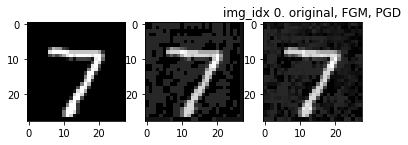

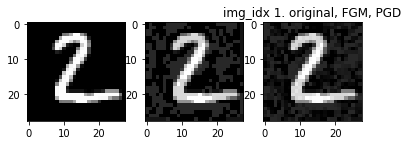

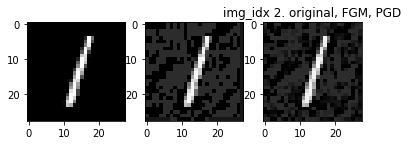

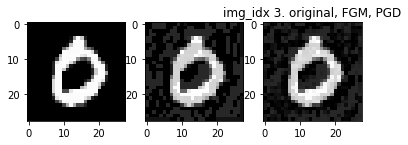

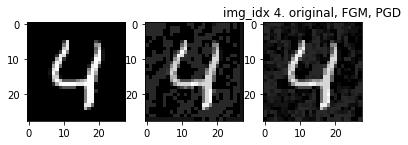

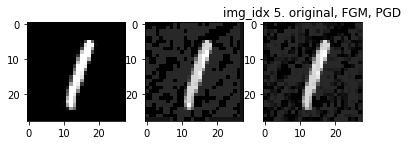

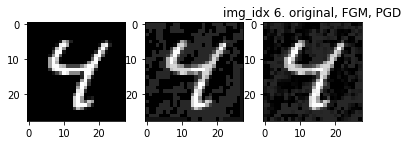

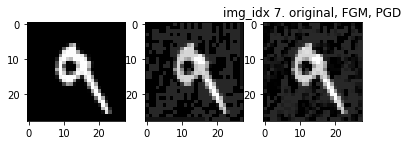

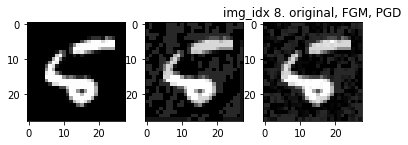

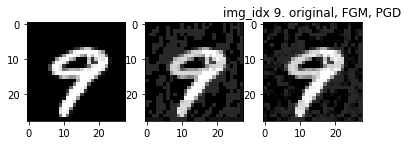

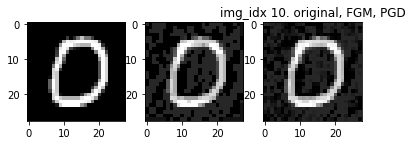

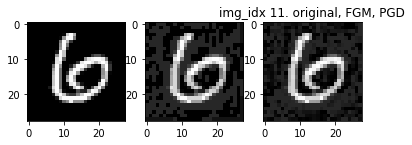

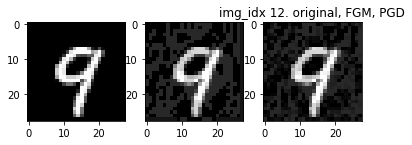

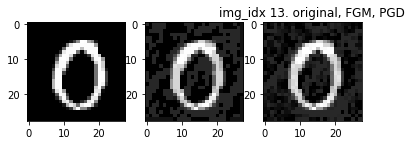

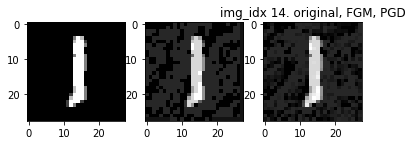

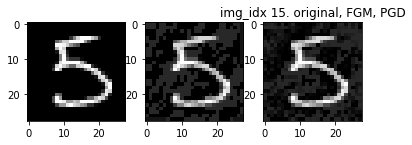

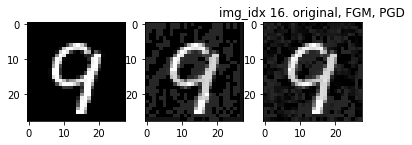

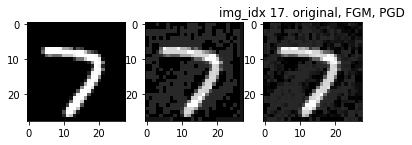

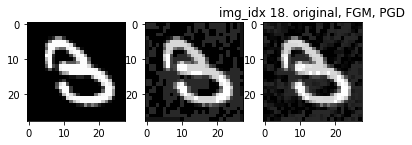

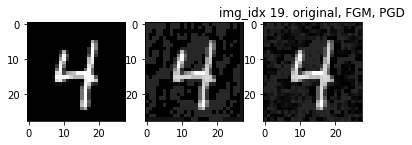

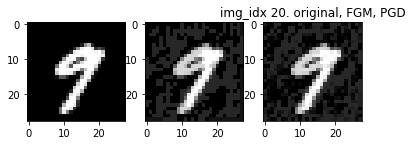

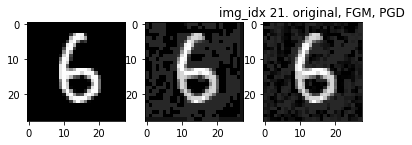

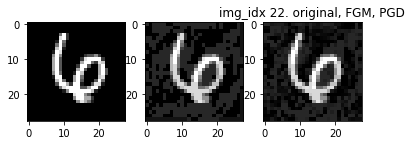

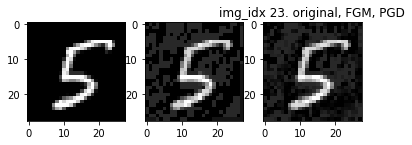

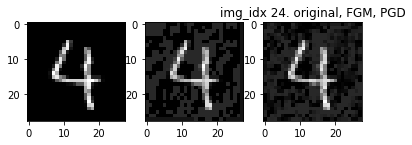

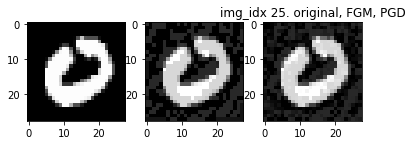

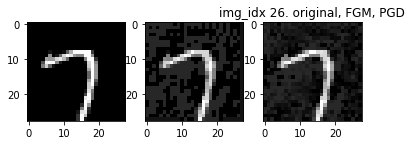

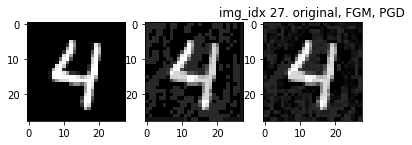

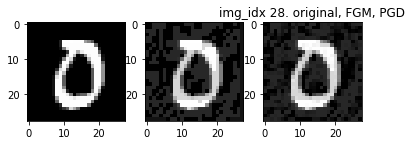

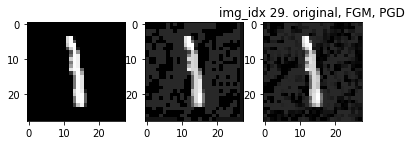

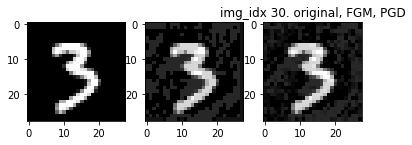

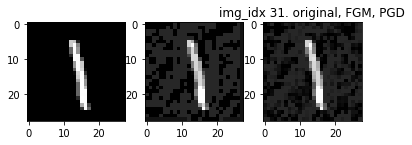

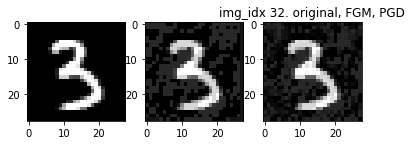

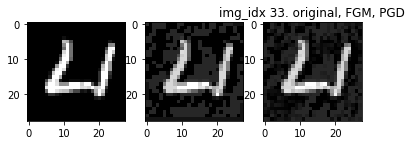

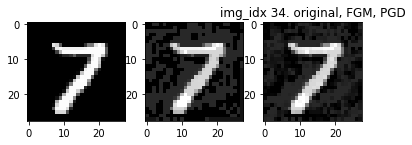

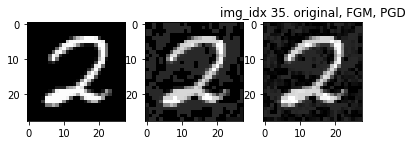

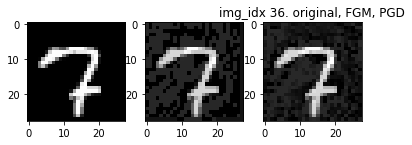

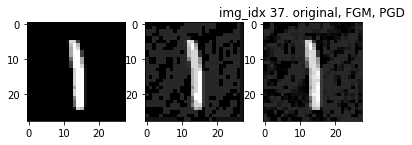

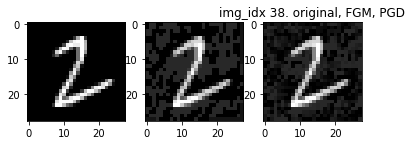

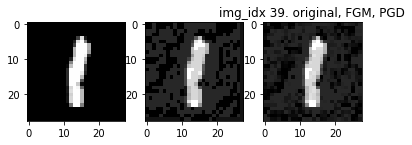

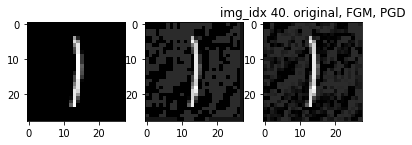

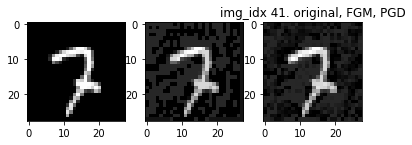

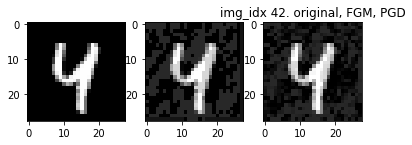

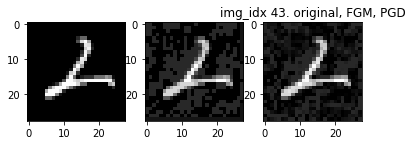

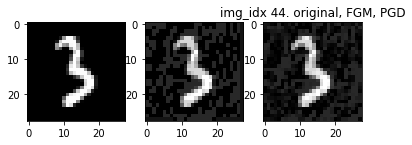

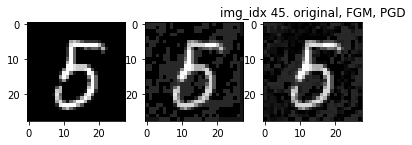

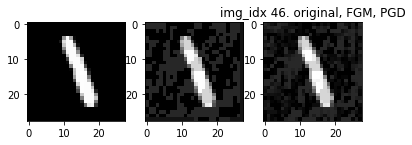

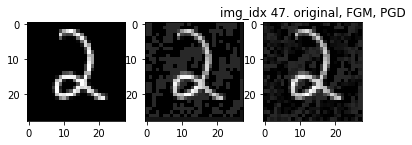

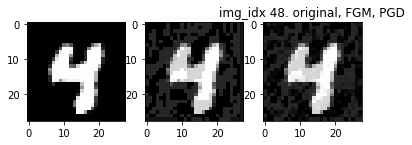

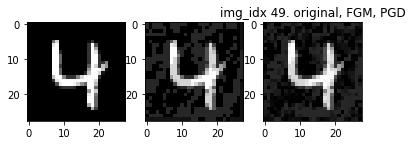

In [12]:
total = 50

org_ratio = 0
fgm_ratio = 0
pgd_ratio = 0

org_counterexample = []
fgm_counterexample = []
pgd_counterexample = []


for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]
    
    x_extend = x[None, :]
    
    x_extend= x_extend.to(device)
    x_fgm = fast_gradient_method(model, x_extend, atk_eps, np.inf)
    x_pgd = projected_gradient_descent(model, x_extend, atk_eps, 0.01, 40, np.inf)
#     print(x_fgm)
    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_fgm = model(x_fgm).max(
        1
    )  # model prediction on FGM adversarial examples
    _, y_pred_pgd = model(x_pgd).max(
        1
    )  # model prediction on PGD adversarial examples
    
    print("img_idx: {}, Predictions --- label: {}, original: {}, fgm: {}, pgd: {}".format(img_idx, y, y_pred.item(), y_pred_fgm.item(), y_pred_pgd.item()))
    
    
    org_pattern = model.get_pattern(x_extend, layers, device, flatten = True)
    fgm_pattern = model.get_pattern(x_fgm, layers, device, flatten = True)
    pgd_pattern = model.get_pattern(x_pgd, layers, device, flatten = True)
    
    
    org_fgm_checking = org_pattern == fgm_pattern
    org_pgd_checking = org_pattern == pgd_pattern
    
    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_fgm_checking = alpha_pattern == fgm_pattern[:, stable_idx]
    alp_pgd_checking = alpha_pattern == pgd_pattern[:, stable_idx]
    
    print("same activation status ratio for org and fgm:", org_fgm_checking.sum()/len(org_fgm_checking[0]) )
    print("same activation status ratio for org and pgd:", org_pgd_checking.sum()/len(org_pgd_checking[0]) )
    
    print("\n")
    
    print("label: {}, org_pred: {}".format( y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum()== len(alp_org_checking[0]), "\n" )
    print("label: {}, fgm_pred: {}".format( y, y_pred_fgm.item()))
    print("same alpha pattern for fgm:", alp_fgm_checking.sum()== len(alp_fgm_checking[0]),"\n" )
    print("label: {}, pgd_pred: {}".format( y, y_pred_pgd.item()))
    print("same alpha pattern for pgd:", alp_pgd_checking.sum()== len(alp_pgd_checking[0]),"\n" )
    
    if (y==y_pred.item() and alp_org_checking.sum()== len(alp_org_checking[0])) or (y!=y_pred.item() and alp_org_checking.sum()!= len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)
        
    if (y==y_pred_fgm.item() and alp_fgm_checking.sum()== len(alp_fgm_checking[0])) or (y!=y_pred_fgm.item() and alp_fgm_checking.sum()!= len(alp_fgm_checking[0])):
        fgm_ratio += 1
    else:
        fgm_counterexample.append(img_idx)
        
    if (y==y_pred_pgd.item() and alp_pgd_checking.sum()== len(alp_pgd_checking[0])) or (y!=y_pred_pgd.item() and alp_pgd_checking.sum()!= len(alp_pgd_checking[0])):
        pgd_ratio += 1
    else:
        pgd_counterexample.append(img_idx)
        
    print("===========")
#     figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_fgm[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].imshow(x_pgd[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, FGM, PGD".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
fgm_ratio = fgm_ratio / total
pgd_ratio = pgd_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format( org_ratio, org_counterexample))
print("fgm pred check consistent with alpha pattern check ratio: {}\n fgm counter examples image idx: {}\n".format( fgm_ratio, fgm_counterexample))
print("pgd pred check consistent with alpha pattern check ratio: {}\n pgd counter examples image idx: {}\n".format( pgd_ratio, pgd_counterexample))

img_idx: 0, Predictions --- label: 7, original: 7, ns: 7
same activation status ratio for org and ns: 0.899155083128918


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, ns_pred: 7
same alpha pattern for ns: False 

img_idx: 1, Predictions --- label: 2, original: 2, ns: 2
same activation status ratio for org and ns: 0.9200054510765876


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, ns_pred: 2
same alpha pattern for ns: False 

img_idx: 2, Predictions --- label: 1, original: 1, ns: 1
same activation status ratio for org and ns: 0.8919324066503135


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, ns_pred: 1
same alpha pattern for ns: False 

img_idx: 3, Predictions --- label: 0, original: 0, ns: 0
same activation status ratio for org and ns: 0.928045789043336


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, ns_pred: 0
same alpha pattern for ns: False 

img_idx: 4, Predictions --- label: 4, original: 4, ns: 4
s

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_20376\1290616289.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,2)


img_idx: 24, Predictions --- label: 4, original: 4, ns: 4
same activation status ratio for org and ns: 0.9032433905696375


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, ns_pred: 4
same alpha pattern for ns: False 

img_idx: 25, Predictions --- label: 0, original: 0, ns: 0
same activation status ratio for org and ns: 0.9559825565549196


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, ns_pred: 0
same alpha pattern for ns: False 

img_idx: 26, Predictions --- label: 7, original: 7, ns: 7
same activation status ratio for org and ns: 0.8980648678113927


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, ns_pred: 7
same alpha pattern for ns: False 

img_idx: 27, Predictions --- label: 4, original: 4, ns: 4
same activation status ratio for org and ns: 0.9149632052330335


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, ns_pred: 4
same alpha pattern for ns: False 

img_idx: 28, Predictions --- label: 0, original: 0, 

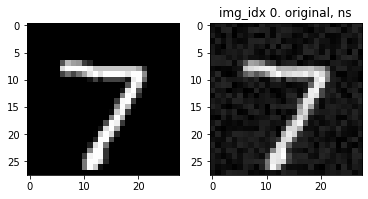

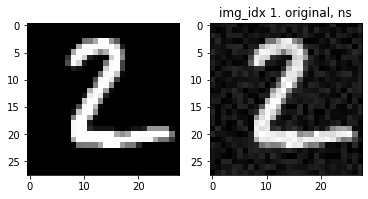

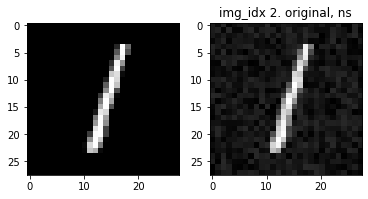

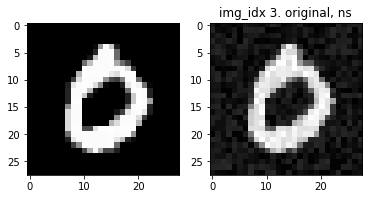

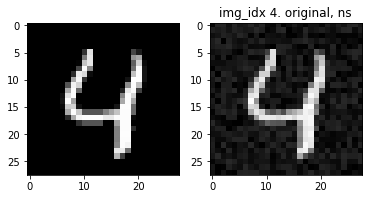

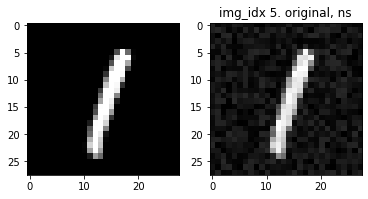

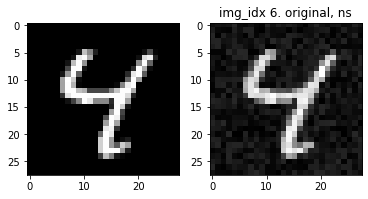

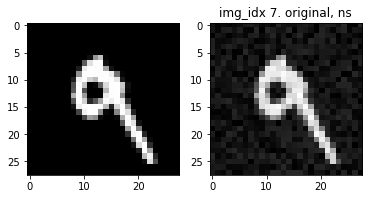

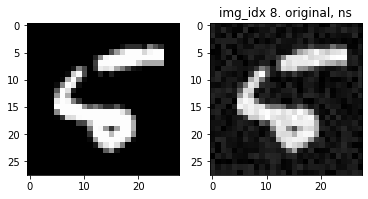

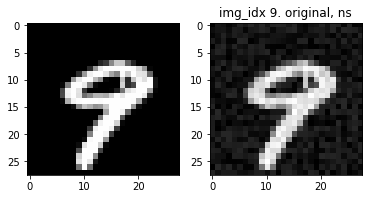

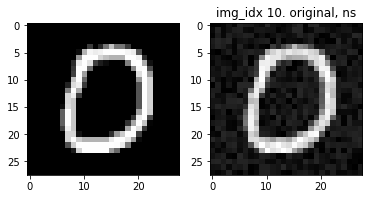

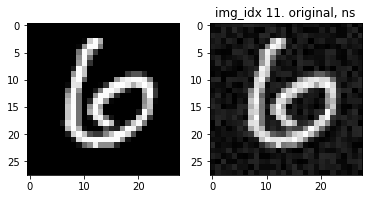

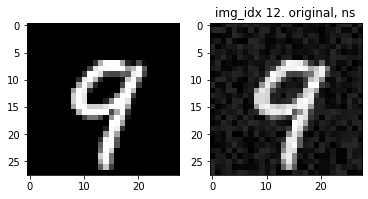

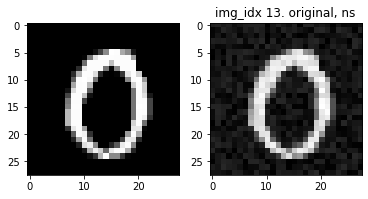

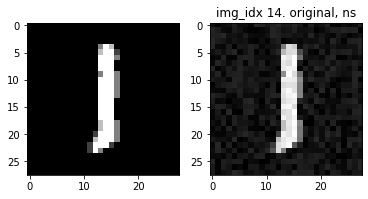

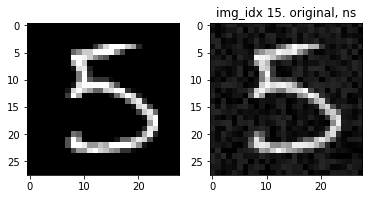

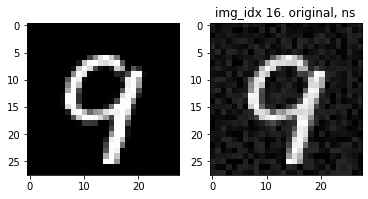

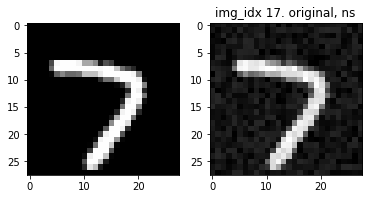

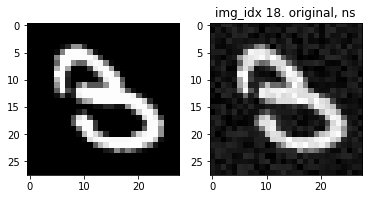

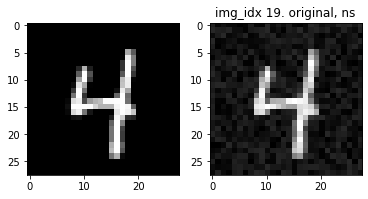

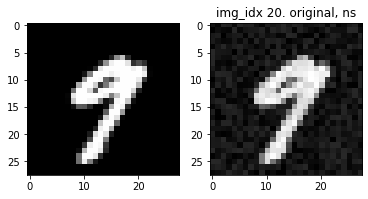

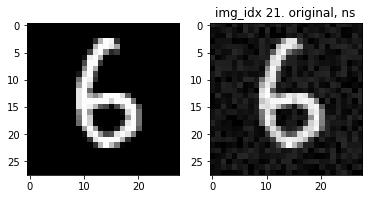

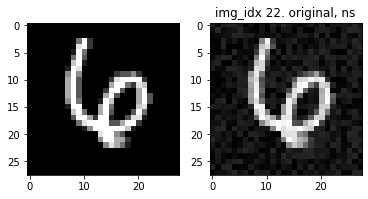

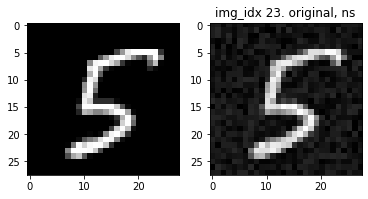

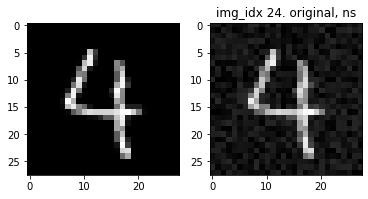

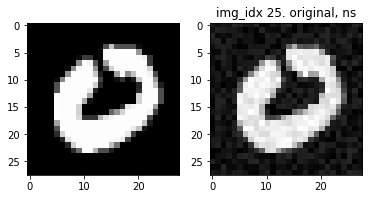

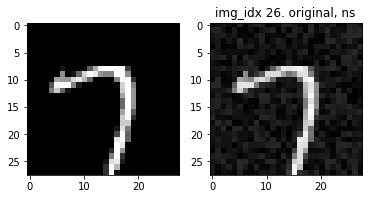

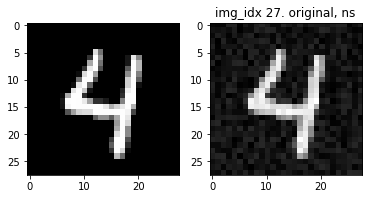

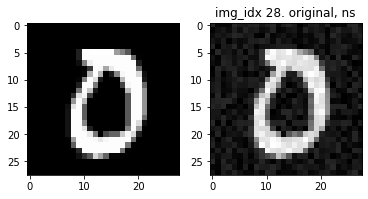

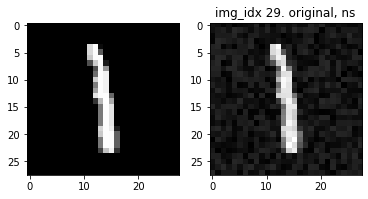

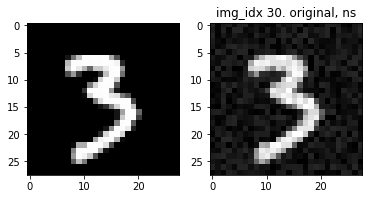

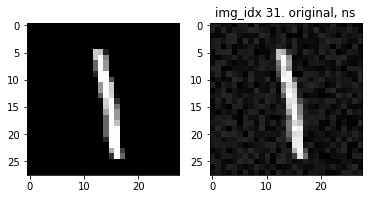

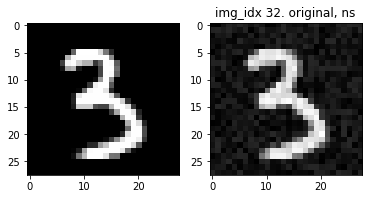

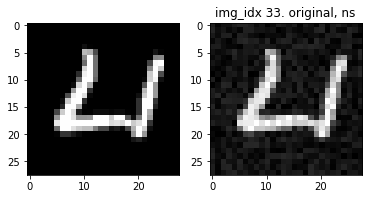

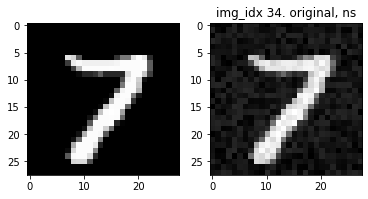

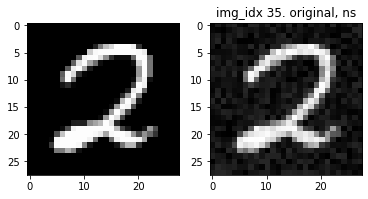

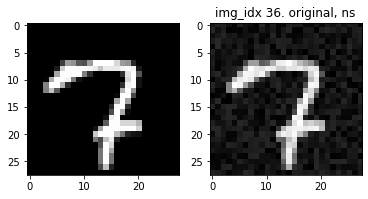

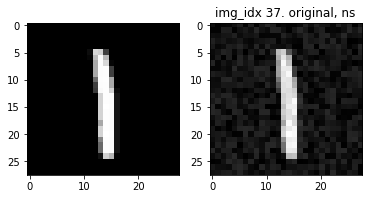

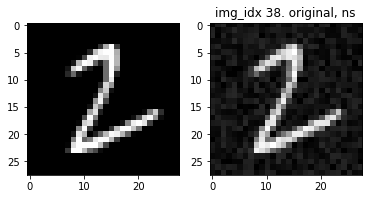

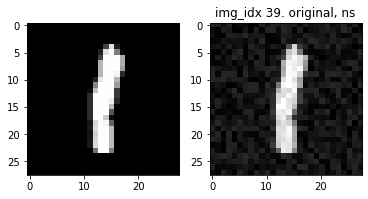

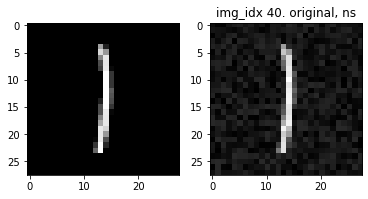

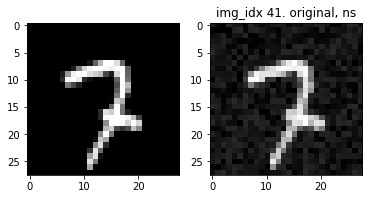

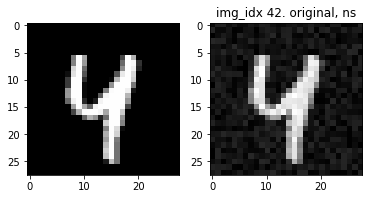

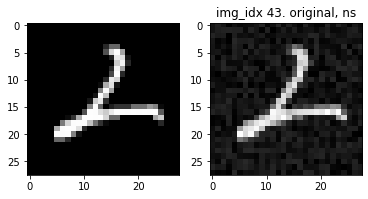

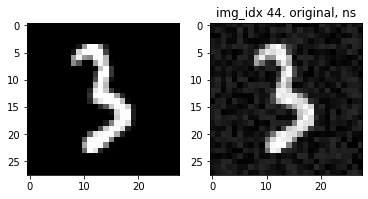

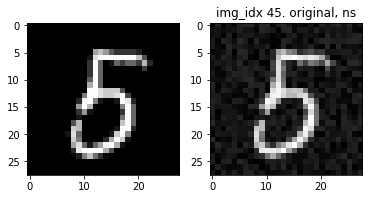

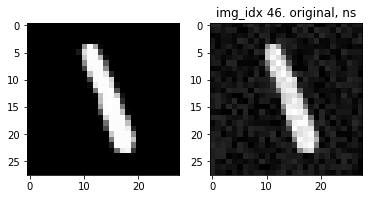

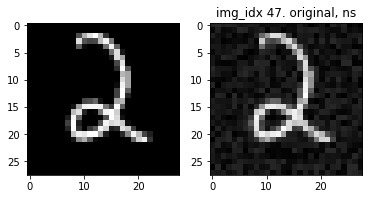

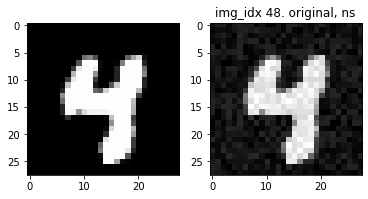

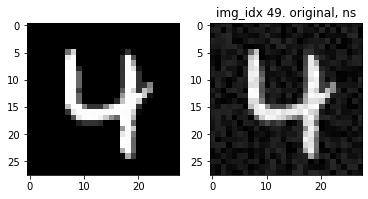

In [15]:
total = 50

org_ratio = 0
ns_ratio = 0


org_counterexample = []
ns_counterexample = []



for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]
    
    x_extend = x[None, :]
    
    x_extend= x_extend.to(device)
    x_ns = noise(x_extend, atk_eps, np.inf)
   
    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_ns= model(x_ns).max(
        1
    )  # model prediction on FGM adversarial examples
   
    print("img_idx: {}, Predictions --- label: {}, original: {}, ns: {}".format(img_idx, y, y_pred.item(), y_pred_ns.item()))
    
    
    org_pattern = model.get_pattern(x_extend, layers, device, flatten = True)
    ns_pattern = model.get_pattern(x_ns, layers, device, flatten = True)
    
    
    org_ns_checking = org_pattern == ns_pattern
    
    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_ns_checking = alpha_pattern == ns_pattern[:, stable_idx]
    
    print("same activation status ratio for org and ns:", org_ns_checking.sum()/len(org_ns_checking[0]) )
    
    print("\n")
    
    print("label: {}, org_pred: {}".format( y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum()== len(alp_org_checking[0]), "\n" )
    print("label: {}, ns_pred: {}".format( y, y_pred_ns.item()))
    print("same alpha pattern for ns:", alp_ns_checking.sum()== len(alp_ns_checking[0]),"\n" )

    
    if (y==y_pred.item() and alp_org_checking.sum()== len(alp_org_checking[0])) or (y!=y_pred.item() and alp_org_checking.sum()!= len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)
        
    if (y==y_pred_ns.item() and alp_ns_checking.sum()== len(alp_ns_checking[0])) or (y!=y_pred_ns.item() and alp_ns_checking.sum()!= len(alp_ns_checking[0])):
        ns_ratio += 1
    else:
        ns_counterexample.append(img_idx)
        
   
        
    print("===========")
#     figure = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_ns[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, ns".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
ns_ratio = ns_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format( org_ratio, org_counterexample))
print("ns pred check consistent with alpha pattern check ratio: {}\n ns counter examples image idx: {}\n".format( ns_ratio, ns_counterexample))


iteration: 1, 2 distance 1.4101E+01
iteration: 2, 2 distance 1.2768E+01
iteration: 3, 2 distance 1.2865E+01
iteration: 4, 2 distance 1.2147E+01
iteration: 5, 2 distance 1.2004E+01
iteration: 6, 2 distance 1.1963E+01
iteration: 7, 2 distance 1.2308E+01
iteration: 8, 2 distance 1.2235E+01
iteration: 9, 2 distance 1.2135E+01
iteration: 10, 2 distance 1.2185E+01
iteration: 11, 2 distance 1.2322E+01
iteration: 12, 2 distance 1.2410E+01
iteration: 13, 2 distance 1.2426E+01
iteration: 14, 2 distance 1.2349E+01
iteration: 15, 2 distance 1.2460E+01
iteration: 16, 2 distance 1.2479E+01
iteration: 17, 2 distance 1.2819E+01
iteration: 18, 2 distance 1.2537E+01
iteration: 19, 2 distance 1.2749E+01
iteration: 20, 2 distance 1.2692E+01
iteration: 21, 2 distance 1.2616E+01
iteration: 22, 2 distance 1.2798E+01
iteration: 23, 2 distance 1.2719E+01
iteration: 24, 2 distance 1.2808E+01
iteration: 25, 2 distance 1.2949E+01
iteration: 26, 2 distance 1.2835E+01
iteration: 27, 2 distance 1.2865E+01
iteration:

iteration: 11, 2 distance 1.6172E+01
iteration: 12, 2 distance 1.6552E+01
iteration: 13, 2 distance 1.6061E+01
iteration: 14, 2 distance 1.6297E+01
iteration: 15, 2 distance 1.6348E+01
iteration: 16, 2 distance 1.6068E+01
iteration: 17, 2 distance 1.6261E+01
iteration: 18, 2 distance 1.6508E+01
iteration: 19, 2 distance 1.6385E+01
iteration: 20, 2 distance 1.6809E+01
iteration: 21, 2 distance 1.6495E+01
iteration: 22, 2 distance 1.6637E+01
iteration: 23, 2 distance 1.6708E+01
iteration: 24, 2 distance 1.6572E+01
iteration: 25, 2 distance 1.6816E+01
iteration: 26, 2 distance 1.6924E+01
iteration: 27, 2 distance 1.6969E+01
iteration: 28, 2 distance 1.6988E+01
iteration: 29, 2 distance 1.7004E+01
iteration: 30, 2 distance 1.6854E+01
iteration: 31, 2 distance 1.6937E+01
iteration: 32, 2 distance 1.6978E+01
iteration: 33, 2 distance 1.7071E+01
iteration: 34, 2 distance 1.7204E+01
iteration: 35, 2 distance 1.7172E+01
iteration: 36, 2 distance 1.6955E+01
iteration: 37, 2 distance 1.7108E+01
i

iteration: 21, 2 distance 8.8592E+00
iteration: 22, 2 distance 8.6380E+00
iteration: 23, 2 distance 8.4387E+00
iteration: 24, 2 distance 8.6094E+00
iteration: 25, 2 distance 8.7898E+00
iteration: 26, 2 distance 8.8096E+00
iteration: 27, 2 distance 8.7433E+00
iteration: 28, 2 distance 8.7672E+00
iteration: 29, 2 distance 8.7310E+00
iteration: 30, 2 distance 8.8764E+00
iteration: 31, 2 distance 9.0254E+00
iteration: 32, 2 distance 8.9876E+00
iteration: 33, 2 distance 8.9865E+00
iteration: 34, 2 distance 9.1131E+00
iteration: 35, 2 distance 9.1103E+00
iteration: 36, 2 distance 9.0504E+00
iteration: 37, 2 distance 9.1124E+00
iteration: 38, 2 distance 9.1970E+00
iteration: 39, 2 distance 9.0416E+00
iteration: 40, 2 distance 9.2161E+00
iteration: 41, 2 distance 9.1478E+00
iteration: 42, 2 distance 9.3132E+00
iteration: 43, 2 distance 9.3042E+00
iteration: 44, 2 distance 9.2853E+00
iteration: 45, 2 distance 9.3154E+00
iteration: 46, 2 distance 9.3475E+00
iteration: 47, 2 distance 9.4174E+00
i

iteration: 31, 2 distance 1.3724E+01
iteration: 32, 2 distance 1.3798E+01
iteration: 33, 2 distance 1.3988E+01
iteration: 34, 2 distance 1.3669E+01
iteration: 35, 2 distance 1.3845E+01
iteration: 36, 2 distance 1.3866E+01
iteration: 37, 2 distance 1.3759E+01
iteration: 38, 2 distance 1.3882E+01
iteration: 39, 2 distance 1.3908E+01
iteration: 40, 2 distance 1.3952E+01
iteration: 41, 2 distance 1.3875E+01
iteration: 42, 2 distance 1.3891E+01
iteration: 43, 2 distance 1.4013E+01
iteration: 44, 2 distance 1.4081E+01
iteration: 45, 2 distance 1.4165E+01
iteration: 46, 2 distance 1.4336E+01
iteration: 47, 2 distance 1.4344E+01
iteration: 48, 2 distance 1.4115E+01
iteration: 49, 2 distance 1.4048E+01
iteration: 50, 2 distance 1.4293E+01
iteration: 51, 2 distance 1.4373E+01
iteration: 52, 2 distance 1.4255E+01
iteration: 53, 2 distance 1.4291E+01
iteration: 54, 2 distance 1.4290E+01
iteration: 55, 2 distance 1.4285E+01
iteration: 56, 2 distance 1.4315E+01
iteration: 57, 2 distance 1.4514E+01
i

iteration: 41, 2 distance 1.4420E+01
iteration: 42, 2 distance 1.4291E+01
iteration: 43, 2 distance 1.4234E+01
iteration: 44, 2 distance 1.4477E+01
iteration: 45, 2 distance 1.4367E+01
iteration: 46, 2 distance 1.4508E+01
iteration: 47, 2 distance 1.4540E+01
iteration: 48, 2 distance 1.4727E+01
iteration: 49, 2 distance 1.4543E+01
iteration: 50, 2 distance 1.4471E+01
iteration: 51, 2 distance 1.4429E+01
iteration: 52, 2 distance 1.4518E+01
iteration: 53, 2 distance 1.4468E+01
iteration: 54, 2 distance 1.4458E+01
iteration: 55, 2 distance 1.4642E+01
iteration: 56, 2 distance 1.4576E+01
iteration: 57, 2 distance 1.4572E+01
iteration: 58, 2 distance 1.4511E+01
iteration: 59, 2 distance 1.4544E+01
iteration: 60, 2 distance 1.4695E+01
iteration: 61, 2 distance 1.4632E+01
iteration: 62, 2 distance 1.4600E+01
iteration: 63, 2 distance 1.4724E+01
iteration: 64, 2 distance 1.4554E+01
img_idx: 12, Predictions --- label: 9, original: 9, hsja: 9
same activation status ratio for org and hsja: 0.840

iteration: 51, 2 distance 6.9718E+00
iteration: 52, 2 distance 7.2943E+00
iteration: 53, 2 distance 6.9457E+00
iteration: 54, 2 distance 7.2141E+00
iteration: 55, 2 distance 7.0480E+00
iteration: 56, 2 distance 7.2792E+00
iteration: 57, 2 distance 7.1177E+00
iteration: 58, 2 distance 7.1250E+00
iteration: 59, 2 distance 7.2290E+00
iteration: 60, 2 distance 7.2922E+00
iteration: 61, 2 distance 7.0970E+00
iteration: 62, 2 distance 7.2714E+00
iteration: 63, 2 distance 7.3495E+00
iteration: 64, 2 distance 7.3355E+00
img_idx: 15, Predictions --- label: 5, original: 3, hsja: 3
same activation status ratio for org and hsja: 0.9427636958299264


label: 5, org_pred: 3
same alpha pattern for org: True 

label: 5, hsja_pred: 3
same alpha pattern for hsja: True 

iteration: 1, 2 distance 1.1723E+01
iteration: 2, 2 distance 8.1261E+00
iteration: 3, 2 distance 7.8491E+00
iteration: 4, 2 distance 8.0707E+00
iteration: 5, 2 distance 8.2068E+00
iteration: 6, 2 distance 8.7934E+00
iteration: 7, 2 distan

iteration: 61, 2 distance 6.4391E-04
iteration: 62, 2 distance 6.4391E-04
iteration: 63, 2 distance 6.4391E-04
iteration: 64, 2 distance 6.4391E-04
img_idx: 18, Predictions --- label: 3, original: 3, hsja: 3
same activation status ratio for org and hsja: 1.0


label: 3, org_pred: 3
same alpha pattern for org: True 

label: 3, hsja_pred: 3
same alpha pattern for hsja: True 

iteration: 1, 2 distance 1.3271E+01
iteration: 2, 2 distance 1.1500E+01
iteration: 3, 2 distance 1.1782E+01
iteration: 4, 2 distance 1.0831E+01
iteration: 5, 2 distance 1.1175E+01
iteration: 6, 2 distance 1.1112E+01
iteration: 7, 2 distance 1.0972E+01
iteration: 8, 2 distance 1.0985E+01
iteration: 9, 2 distance 1.1282E+01
iteration: 10, 2 distance 1.1145E+01
iteration: 11, 2 distance 1.1609E+01
iteration: 12, 2 distance 1.1359E+01
iteration: 13, 2 distance 1.1335E+01
iteration: 14, 2 distance 1.1439E+01
iteration: 15, 2 distance 1.1516E+01
iteration: 16, 2 distance 1.1551E+01
iteration: 17, 2 distance 1.1536E+01
ite

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_20376\100166963.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,2)


iteration: 1, 2 distance 9.7257E+00
iteration: 2, 2 distance 9.0514E+00
iteration: 3, 2 distance 9.3393E+00
iteration: 4, 2 distance 9.0878E+00
iteration: 5, 2 distance 9.4338E+00
iteration: 6, 2 distance 9.0773E+00
iteration: 7, 2 distance 9.1884E+00
iteration: 8, 2 distance 9.8710E+00
iteration: 9, 2 distance 9.3980E+00
iteration: 10, 2 distance 9.9979E+00
iteration: 11, 2 distance 9.6862E+00
iteration: 12, 2 distance 9.6897E+00
iteration: 13, 2 distance 9.9721E+00
iteration: 14, 2 distance 9.9189E+00
iteration: 15, 2 distance 1.0173E+01
iteration: 16, 2 distance 1.0070E+01
iteration: 17, 2 distance 1.0173E+01
iteration: 18, 2 distance 1.0083E+01
iteration: 19, 2 distance 1.0221E+01
iteration: 20, 2 distance 1.0683E+01
iteration: 21, 2 distance 1.0570E+01
iteration: 22, 2 distance 1.0745E+01
iteration: 23, 2 distance 1.0538E+01
iteration: 24, 2 distance 1.0534E+01
iteration: 25, 2 distance 1.0613E+01
iteration: 26, 2 distance 1.0714E+01
iteration: 27, 2 distance 1.0800E+01
iteration:

iteration: 12, 2 distance 9.0529E+00
iteration: 13, 2 distance 8.9272E+00
iteration: 14, 2 distance 8.9963E+00
iteration: 15, 2 distance 8.9577E+00
iteration: 16, 2 distance 9.1357E+00
iteration: 17, 2 distance 9.2280E+00
iteration: 18, 2 distance 9.3078E+00
iteration: 19, 2 distance 9.2773E+00
iteration: 20, 2 distance 9.4246E+00
iteration: 21, 2 distance 9.2455E+00
iteration: 22, 2 distance 9.5743E+00
iteration: 23, 2 distance 9.2998E+00
iteration: 24, 2 distance 9.5371E+00
iteration: 25, 2 distance 9.5943E+00
iteration: 26, 2 distance 9.4251E+00
iteration: 27, 2 distance 9.7255E+00
iteration: 28, 2 distance 9.5476E+00
iteration: 29, 2 distance 9.5723E+00
iteration: 30, 2 distance 9.7644E+00
iteration: 31, 2 distance 9.7612E+00
iteration: 32, 2 distance 9.7057E+00
iteration: 33, 2 distance 9.8497E+00
iteration: 34, 2 distance 9.8574E+00
iteration: 35, 2 distance 1.0020E+01
iteration: 36, 2 distance 9.8490E+00
iteration: 37, 2 distance 9.8493E+00
iteration: 38, 2 distance 9.8732E+00
i

iteration: 22, 2 distance 1.2817E+01
iteration: 23, 2 distance 1.2493E+01
iteration: 24, 2 distance 1.2565E+01
iteration: 25, 2 distance 1.2812E+01
iteration: 26, 2 distance 1.2906E+01
iteration: 27, 2 distance 1.2756E+01
iteration: 28, 2 distance 1.2860E+01
iteration: 29, 2 distance 1.2749E+01
iteration: 30, 2 distance 1.2879E+01
iteration: 31, 2 distance 1.2765E+01
iteration: 32, 2 distance 1.2906E+01
iteration: 33, 2 distance 1.2889E+01
iteration: 34, 2 distance 1.3071E+01
iteration: 35, 2 distance 1.2864E+01
iteration: 36, 2 distance 1.3056E+01
iteration: 37, 2 distance 1.2830E+01
iteration: 38, 2 distance 1.3051E+01
iteration: 39, 2 distance 1.3012E+01
iteration: 40, 2 distance 1.2930E+01
iteration: 41, 2 distance 1.3041E+01
iteration: 42, 2 distance 1.3152E+01
iteration: 43, 2 distance 1.3083E+01
iteration: 44, 2 distance 1.3085E+01
iteration: 45, 2 distance 1.3049E+01
iteration: 46, 2 distance 1.3254E+01
iteration: 47, 2 distance 1.3085E+01
iteration: 48, 2 distance 1.3167E+01
i

iteration: 32, 2 distance 1.5302E+01
iteration: 33, 2 distance 1.5416E+01
iteration: 34, 2 distance 1.5535E+01
iteration: 35, 2 distance 1.5562E+01
iteration: 36, 2 distance 1.5711E+01
iteration: 37, 2 distance 1.5778E+01
iteration: 38, 2 distance 1.5603E+01
iteration: 39, 2 distance 1.5588E+01
iteration: 40, 2 distance 1.5873E+01
iteration: 41, 2 distance 1.5748E+01
iteration: 42, 2 distance 1.5579E+01
iteration: 43, 2 distance 1.5689E+01
iteration: 44, 2 distance 1.5841E+01
iteration: 45, 2 distance 1.5898E+01
iteration: 46, 2 distance 1.5870E+01
iteration: 47, 2 distance 1.5754E+01
iteration: 48, 2 distance 1.5827E+01
iteration: 49, 2 distance 1.5859E+01
iteration: 50, 2 distance 1.5686E+01
iteration: 51, 2 distance 1.5723E+01
iteration: 52, 2 distance 1.5767E+01
iteration: 53, 2 distance 1.6044E+01
iteration: 54, 2 distance 1.5727E+01
iteration: 55, 2 distance 1.5819E+01
iteration: 56, 2 distance 1.5963E+01
iteration: 57, 2 distance 1.5899E+01
iteration: 58, 2 distance 1.5879E+01
i

iteration: 42, 2 distance 1.2174E+01
iteration: 43, 2 distance 1.2401E+01
iteration: 44, 2 distance 1.2130E+01
iteration: 45, 2 distance 1.2195E+01
iteration: 46, 2 distance 1.2571E+01
iteration: 47, 2 distance 1.2224E+01
iteration: 48, 2 distance 1.2264E+01
iteration: 49, 2 distance 1.2433E+01
iteration: 50, 2 distance 1.2354E+01
iteration: 51, 2 distance 1.2343E+01
iteration: 52, 2 distance 1.2198E+01
iteration: 53, 2 distance 1.2294E+01
iteration: 54, 2 distance 1.2362E+01
iteration: 55, 2 distance 1.2447E+01
iteration: 56, 2 distance 1.2495E+01
iteration: 57, 2 distance 1.2534E+01
iteration: 58, 2 distance 1.2563E+01
iteration: 59, 2 distance 1.2606E+01
iteration: 60, 2 distance 1.2447E+01
iteration: 61, 2 distance 1.2747E+01
iteration: 62, 2 distance 1.2614E+01
iteration: 63, 2 distance 1.2603E+01
iteration: 64, 2 distance 1.3015E+01
img_idx: 33, Predictions --- label: 4, original: 0, hsja: 0
same activation status ratio for org and hsja: 0.8637230853093486


label: 4, org_pred: 0

iteration: 52, 2 distance 1.4284E+01
iteration: 53, 2 distance 1.4325E+01
iteration: 54, 2 distance 1.4286E+01
iteration: 55, 2 distance 1.4287E+01
iteration: 56, 2 distance 1.4467E+01
iteration: 57, 2 distance 1.4488E+01
iteration: 58, 2 distance 1.4516E+01
iteration: 59, 2 distance 1.4387E+01
iteration: 60, 2 distance 1.4560E+01
iteration: 61, 2 distance 1.4487E+01
iteration: 62, 2 distance 1.4465E+01
iteration: 63, 2 distance 1.4441E+01
iteration: 64, 2 distance 1.4477E+01
img_idx: 36, Predictions --- label: 7, original: 7, hsja: 7
same activation status ratio for org and hsja: 0.8371490869446716


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, hsja_pred: 7
same alpha pattern for hsja: False 

iteration: 1, 2 distance 4.9325E-04
iteration: 2, 2 distance 4.9325E-04
iteration: 3, 2 distance 4.9325E-04
iteration: 4, 2 distance 4.9325E-04
iteration: 5, 2 distance 4.9325E-04
iteration: 6, 2 distance 4.9325E-04
iteration: 7, 2 distance 4.9325E-04
iteration: 8, 2 distan

iteration: 62, 2 distance 5.3677E-04
iteration: 63, 2 distance 5.3677E-04
iteration: 64, 2 distance 5.3677E-04
img_idx: 39, Predictions --- label: 1, original: 1, hsja: 1
same activation status ratio for org and hsja: 1.0


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, hsja_pred: 1
same alpha pattern for hsja: True 

iteration: 1, 2 distance 4.1862E-04
iteration: 2, 2 distance 4.1862E-04
iteration: 3, 2 distance 4.1862E-04
iteration: 4, 2 distance 4.1862E-04
iteration: 5, 2 distance 4.1862E-04
iteration: 6, 2 distance 4.1862E-04
iteration: 7, 2 distance 4.1862E-04
iteration: 8, 2 distance 4.1862E-04
iteration: 9, 2 distance 4.1862E-04
iteration: 10, 2 distance 4.1862E-04
iteration: 11, 2 distance 4.1862E-04
iteration: 12, 2 distance 4.1862E-04
iteration: 13, 2 distance 4.1862E-04
iteration: 14, 2 distance 4.1862E-04
iteration: 15, 2 distance 4.1862E-04
iteration: 16, 2 distance 4.1862E-04
iteration: 17, 2 distance 4.1862E-04
iteration: 18, 2 distance 4.1862E-04
ite

iteration: 5, 2 distance 1.2448E+01
iteration: 6, 2 distance 1.2400E+01
iteration: 7, 2 distance 1.2297E+01
iteration: 8, 2 distance 1.2378E+01
iteration: 9, 2 distance 1.2193E+01
iteration: 10, 2 distance 1.2346E+01
iteration: 11, 2 distance 1.2281E+01
iteration: 12, 2 distance 1.2451E+01
iteration: 13, 2 distance 1.2319E+01
iteration: 14, 2 distance 1.2361E+01
iteration: 15, 2 distance 1.2539E+01
iteration: 16, 2 distance 1.2599E+01
iteration: 17, 2 distance 1.2553E+01
iteration: 18, 2 distance 1.2593E+01
iteration: 19, 2 distance 1.2827E+01
iteration: 20, 2 distance 1.2829E+01
iteration: 21, 2 distance 1.2733E+01
iteration: 22, 2 distance 1.2935E+01
iteration: 23, 2 distance 1.2949E+01
iteration: 24, 2 distance 1.3030E+01
iteration: 25, 2 distance 1.2901E+01
iteration: 26, 2 distance 1.2933E+01
iteration: 27, 2 distance 1.3170E+01
iteration: 28, 2 distance 1.3054E+01
iteration: 29, 2 distance 1.3080E+01
iteration: 30, 2 distance 1.3060E+01
iteration: 31, 2 distance 1.3016E+01
iterat

iteration: 15, 2 distance 8.6070E+00
iteration: 16, 2 distance 8.7473E+00
iteration: 17, 2 distance 8.7436E+00
iteration: 18, 2 distance 8.7367E+00
iteration: 19, 2 distance 8.7829E+00
iteration: 20, 2 distance 8.9685E+00
iteration: 21, 2 distance 8.8798E+00
iteration: 22, 2 distance 9.1603E+00
iteration: 23, 2 distance 9.4684E+00
iteration: 24, 2 distance 9.0651E+00
iteration: 25, 2 distance 8.8987E+00
iteration: 26, 2 distance 8.9381E+00
iteration: 27, 2 distance 9.3607E+00
iteration: 28, 2 distance 9.2396E+00
iteration: 29, 2 distance 9.0626E+00
iteration: 30, 2 distance 9.1833E+00
iteration: 31, 2 distance 9.1114E+00
iteration: 32, 2 distance 9.2994E+00
iteration: 33, 2 distance 9.4368E+00
iteration: 34, 2 distance 9.3408E+00
iteration: 35, 2 distance 9.3693E+00
iteration: 36, 2 distance 9.3335E+00
iteration: 37, 2 distance 9.3169E+00
iteration: 38, 2 distance 9.7330E+00
iteration: 39, 2 distance 9.3548E+00
iteration: 40, 2 distance 9.6353E+00
iteration: 41, 2 distance 9.7676E+00
i

iteration: 25, 2 distance 1.3568E+01
iteration: 26, 2 distance 1.3703E+01
iteration: 27, 2 distance 1.3681E+01
iteration: 28, 2 distance 1.3542E+01
iteration: 29, 2 distance 1.3804E+01
iteration: 30, 2 distance 1.3824E+01
iteration: 31, 2 distance 1.3783E+01
iteration: 32, 2 distance 1.3803E+01
iteration: 33, 2 distance 1.3927E+01
iteration: 34, 2 distance 1.3813E+01
iteration: 35, 2 distance 1.4124E+01
iteration: 36, 2 distance 1.4042E+01
iteration: 37, 2 distance 1.4143E+01
iteration: 38, 2 distance 1.3988E+01
iteration: 39, 2 distance 1.4127E+01
iteration: 40, 2 distance 1.4166E+01
iteration: 41, 2 distance 1.4078E+01
iteration: 42, 2 distance 1.4224E+01
iteration: 43, 2 distance 1.4180E+01
iteration: 44, 2 distance 1.4210E+01
iteration: 45, 2 distance 1.4154E+01
iteration: 46, 2 distance 1.4261E+01
iteration: 47, 2 distance 1.4303E+01
iteration: 48, 2 distance 1.4481E+01
iteration: 49, 2 distance 1.4187E+01
iteration: 50, 2 distance 1.4394E+01
iteration: 51, 2 distance 1.4595E+01
i

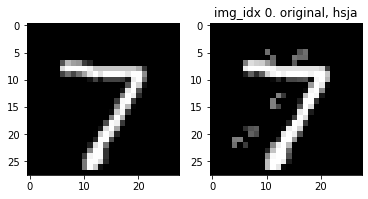

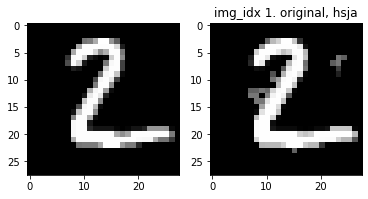

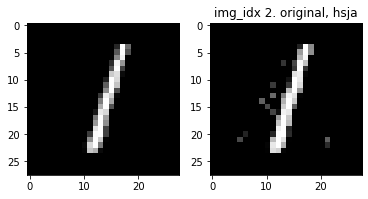

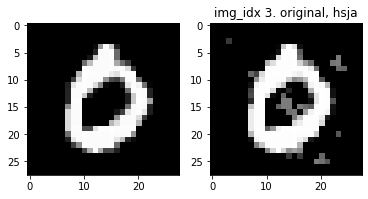

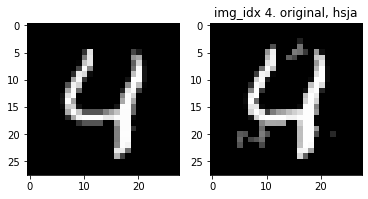

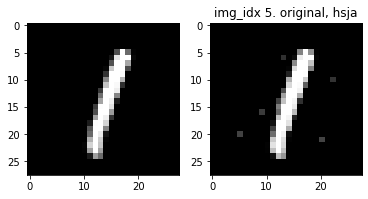

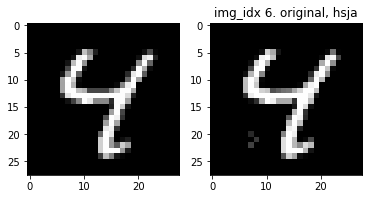

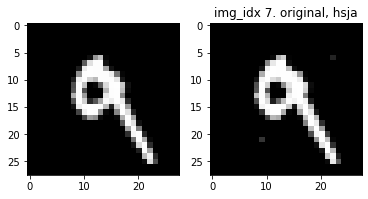

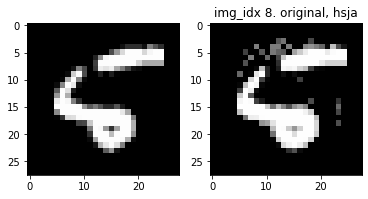

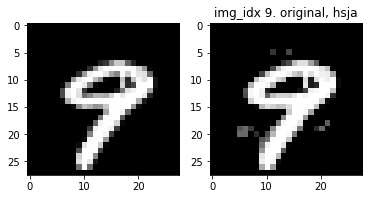

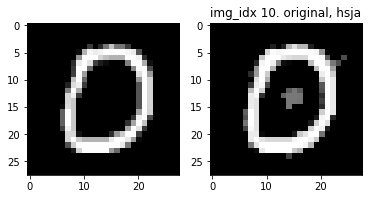

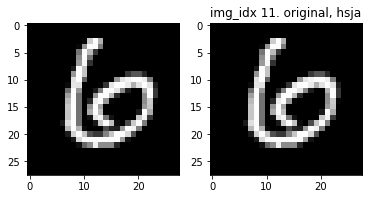

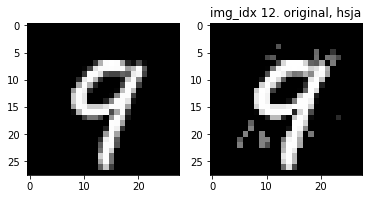

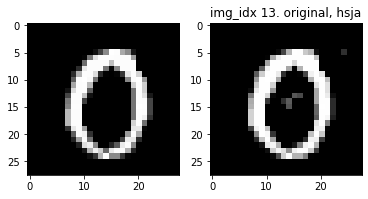

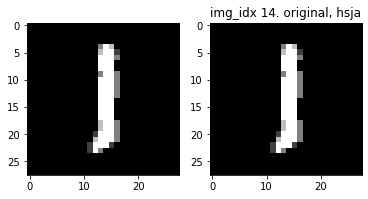

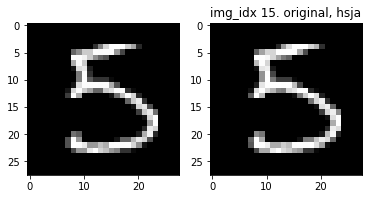

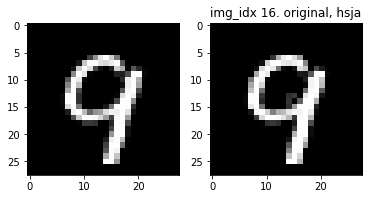

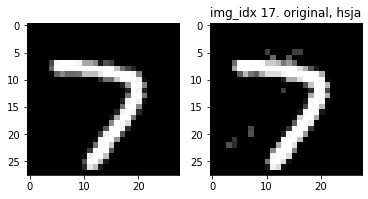

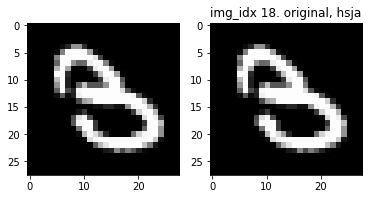

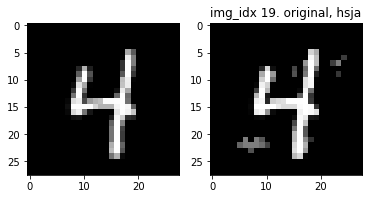

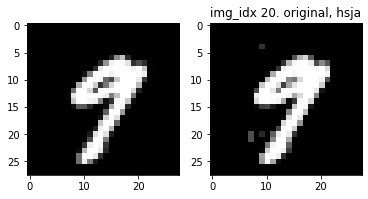

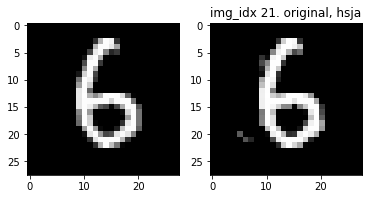

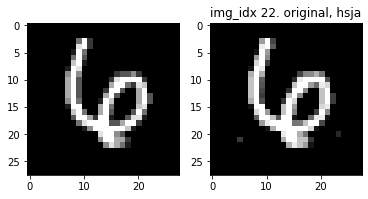

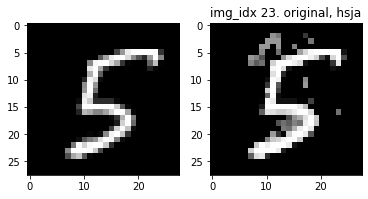

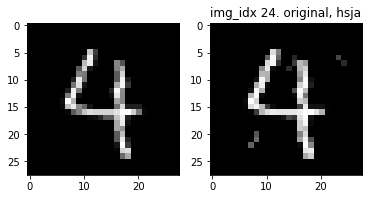

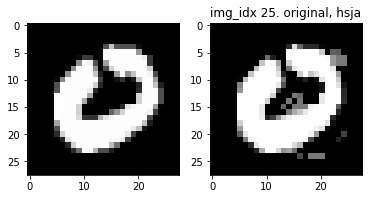

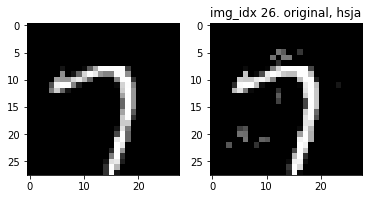

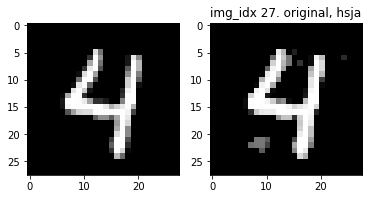

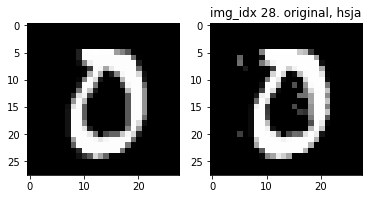

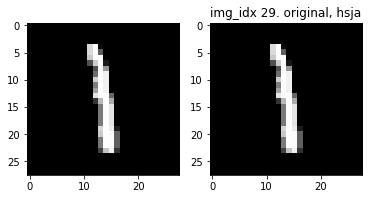

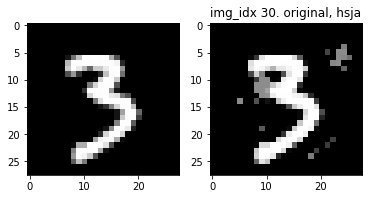

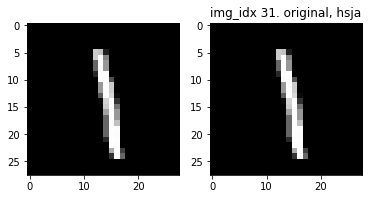

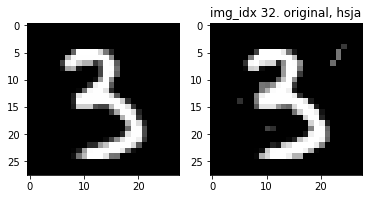

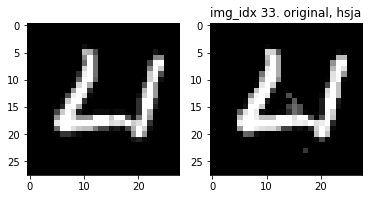

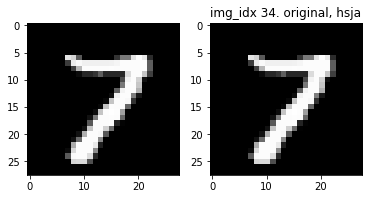

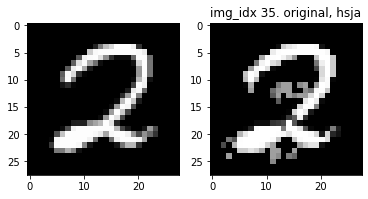

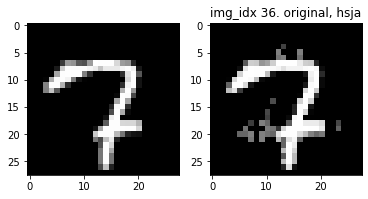

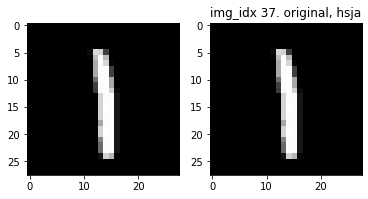

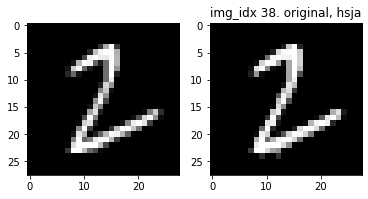

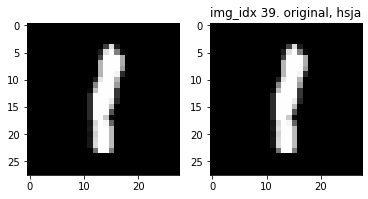

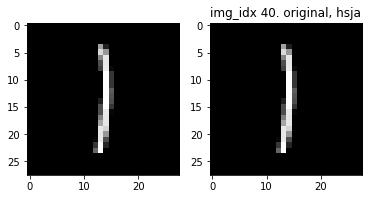

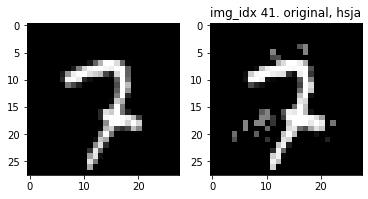

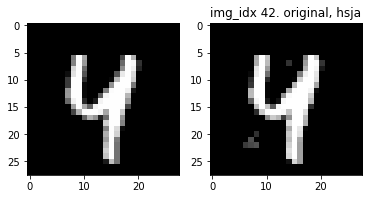

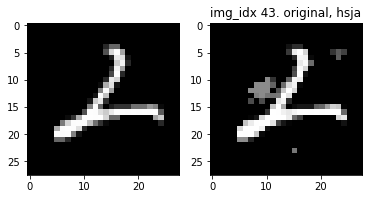

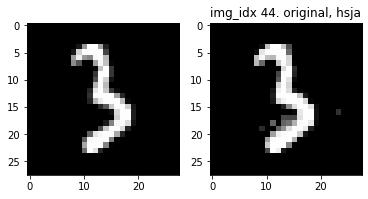

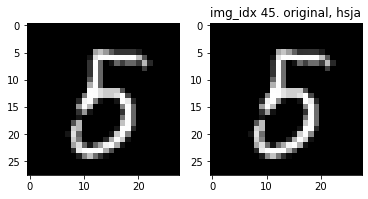

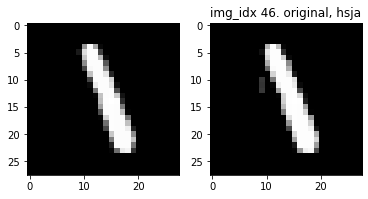

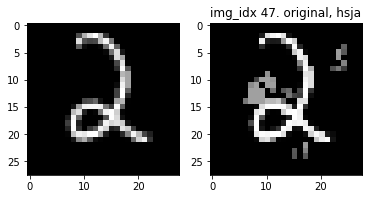

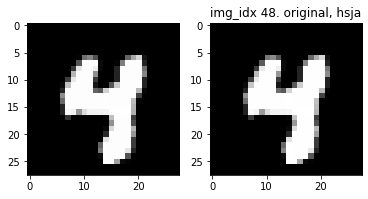

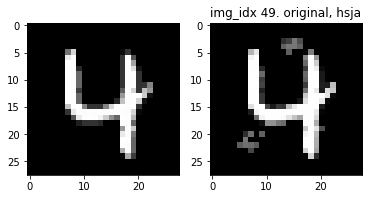

In [17]:
total = 50

org_ratio = 0
hsja_ratio = 0


org_counterexample = []
hsja_counterexample = []



for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]
    
    x_extend = x[None, :]
    
    x_extend= x_extend.to(device)
    x_hsja = hop_skip_jump_attack(model, x_extend, np.inf)
   
    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_hsja= model(x_hsja).max(
        1
    )  # model prediction on FGM adversarial examples
   
    print("img_idx: {}, Predictions --- label: {}, original: {}, hsja: {}".format(img_idx, y, y_pred.item(), y_pred_hsja.item()))
    
    
    org_pattern = model.get_pattern(x_extend, layers, device, flatten = True)
    hsja_pattern = model.get_pattern(x_hsja, layers, device, flatten = True)
    
    
    org_hsja_checking = org_pattern == hsja_pattern
    
    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_hsja_checking = alpha_pattern == hsja_pattern[:, stable_idx]
    
    print("same activation status ratio for org and hsja:", org_hsja_checking.sum()/len(org_hsja_checking[0]) )
    
    print("\n")
    
    print("label: {}, org_pred: {}".format( y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum()== len(alp_org_checking[0]), "\n" )
    print("label: {}, hsja_pred: {}".format( y, y_pred_hsja.item()))
    print("same alpha pattern for hsja:", alp_hsja_checking.sum()== len(alp_hsja_checking[0]),"\n" )

    
    if (y==y_pred.item() and alp_org_checking.sum()== len(alp_org_checking[0])) or (y!=y_pred.item() and alp_org_checking.sum()!= len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)
        
    if (y==y_pred_hsja.item() and alp_hsja_checking.sum()== len(alp_hsja_checking[0])) or (y!=y_pred_hsja.item() and alp_hsja_checking.sum()!= len(alp_hsja_checking[0])):
        hsja_ratio += 1
    else:
        hsja_counterexample.append(img_idx)
        
   
        
    print("===========")
#     figure = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_hsja[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, hsja".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
hsja_ratio = hsja_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format( org_ratio, org_counterexample))
print("hsja pred check consistent with alpha pattern check ratio: {}\n hsja counter examples image idx: {}\n".format( hsja_ratio, hsja_counterexample))

img_idx: 0, Predictions --- label: 7, original: 7, spsa: 7
same activation status ratio for org and spsa: 0.8997001907876806


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, spsa_pred: 7
same alpha pattern for spsa: False 

img_idx: 1, Predictions --- label: 2, original: 2, spsa: 2
same activation status ratio for org and spsa: 0.914418097574271


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, spsa_pred: 2
same alpha pattern for spsa: False 

img_idx: 2, Predictions --- label: 1, original: 1, spsa: 1
same activation status ratio for org and spsa: 0.8893431452711911


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, spsa_pred: 1
same alpha pattern for spsa: False 

img_idx: 3, Predictions --- label: 0, original: 0, spsa: 0
same activation status ratio for org and spsa: 0.9329517579721995


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, spsa_pred: 0
same alpha pattern for spsa: False 

img_idx: 4, Predictions -

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_20376\33460526.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2)


img_idx: 21, Predictions --- label: 6, original: 6, spsa: 6
same activation status ratio for org and spsa: 0.9062414826928318


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, spsa_pred: 6
same alpha pattern for spsa: False 

img_idx: 22, Predictions --- label: 6, original: 6, spsa: 6
same activation status ratio for org and spsa: 0.9204142818206595


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, spsa_pred: 6
same alpha pattern for spsa: False 

img_idx: 23, Predictions --- label: 5, original: 5, spsa: 5
same activation status ratio for org and spsa: 0.9051512673753066


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, spsa_pred: 5
same alpha pattern for spsa: False 

img_idx: 24, Predictions --- label: 4, original: 4, spsa: 4
same activation status ratio for org and spsa: 0.9051512673753066


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, spsa_pred: 4
same alpha pattern for spsa: False 

img_idx: 25, Predict

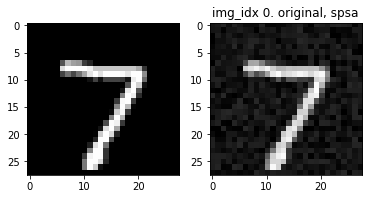

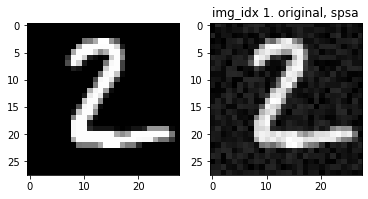

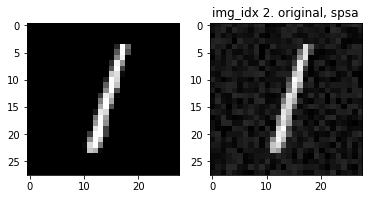

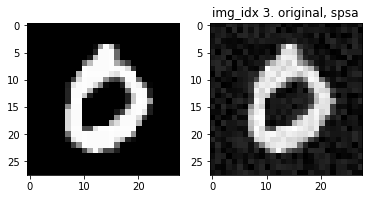

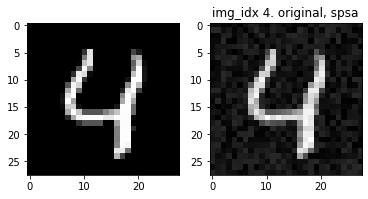

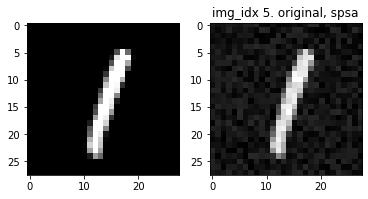

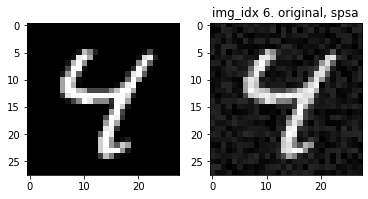

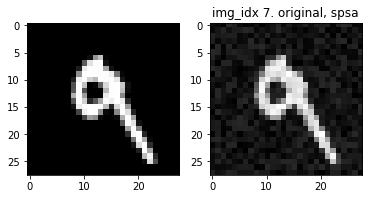

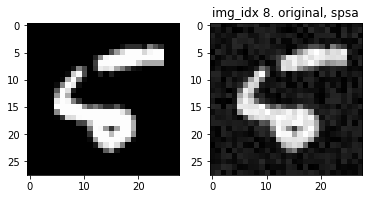

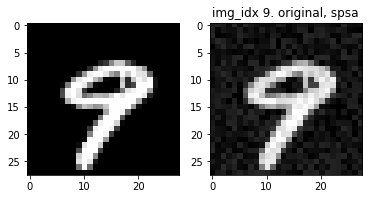

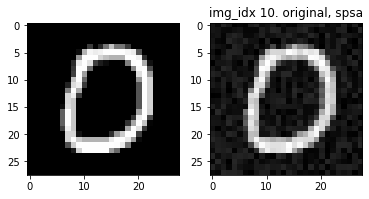

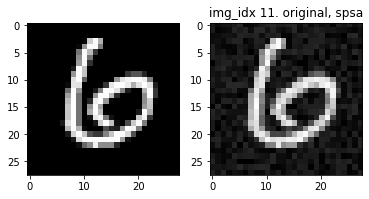

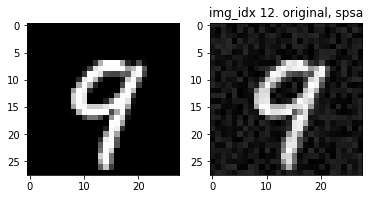

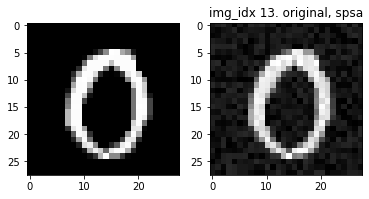

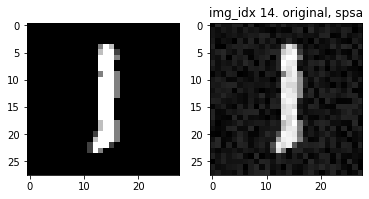

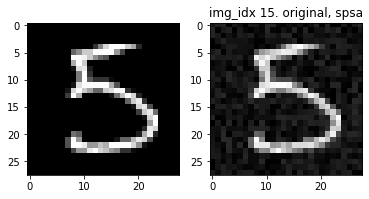

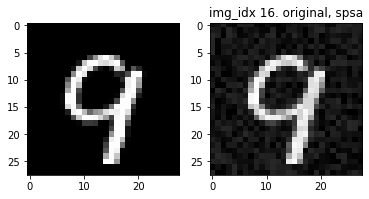

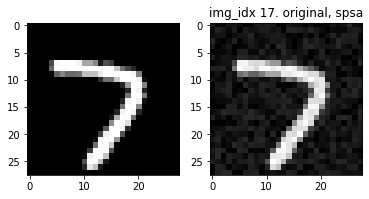

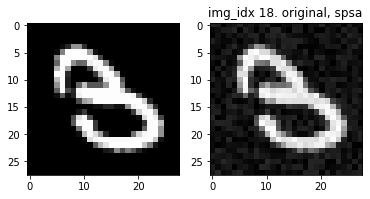

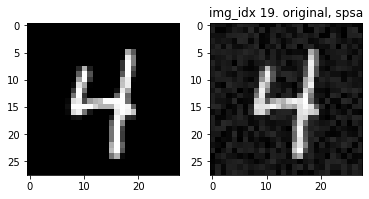

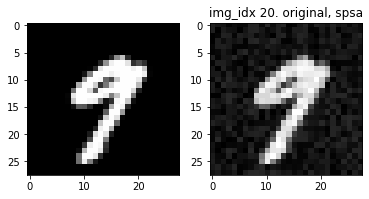

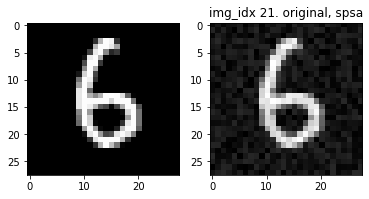

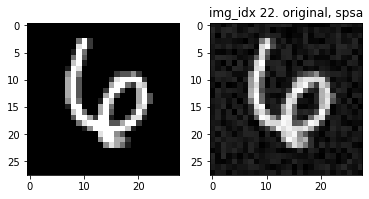

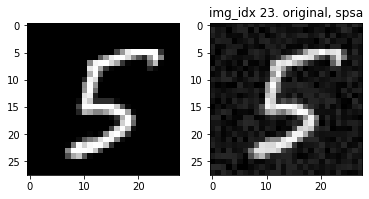

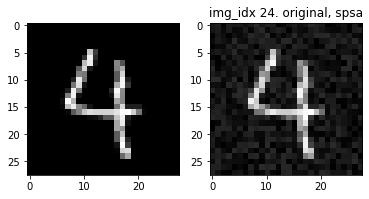

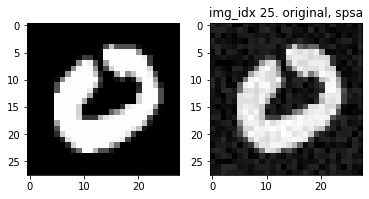

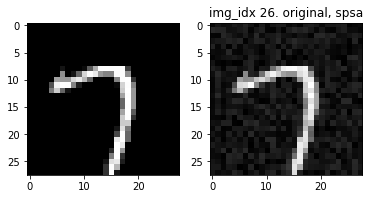

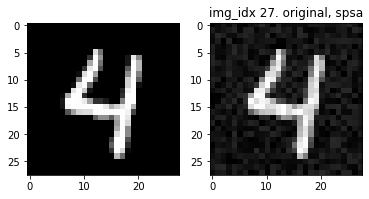

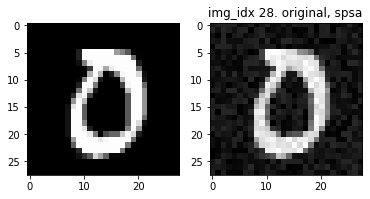

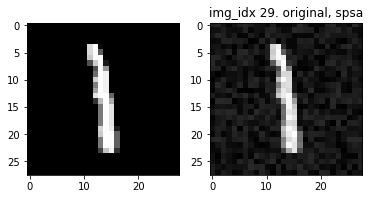

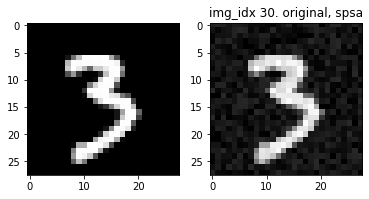

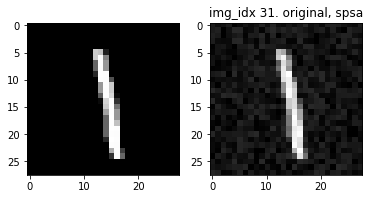

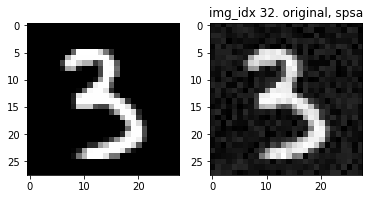

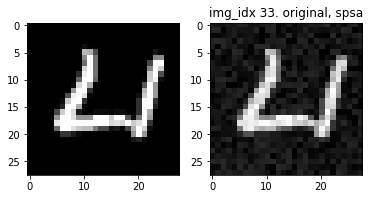

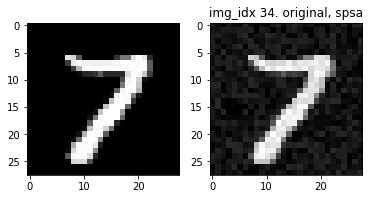

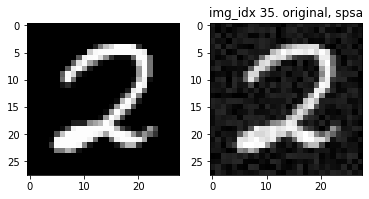

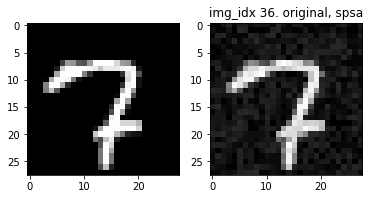

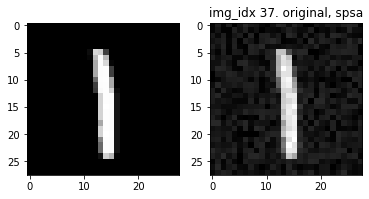

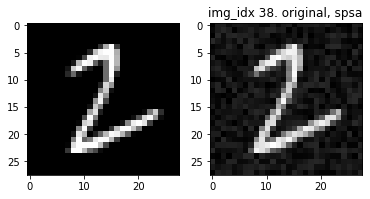

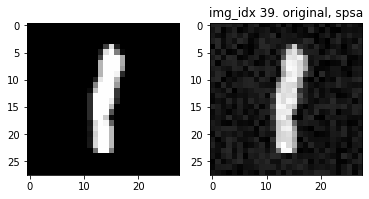

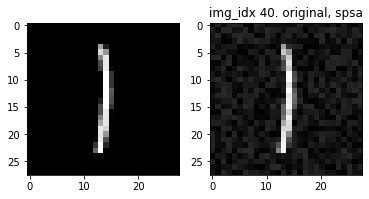

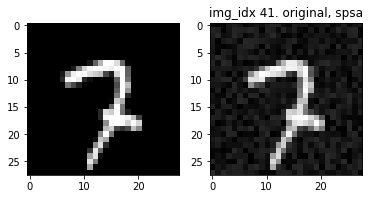

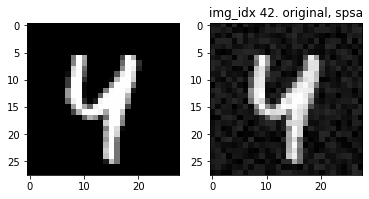

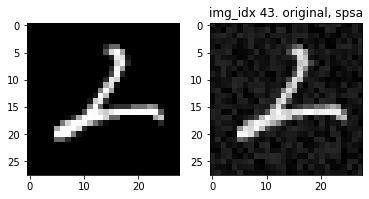

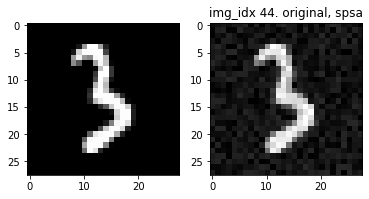

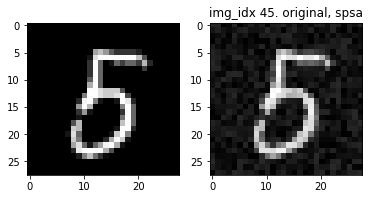

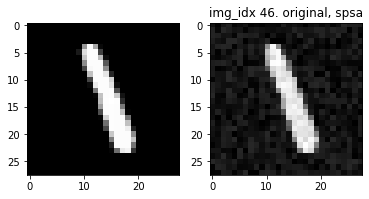

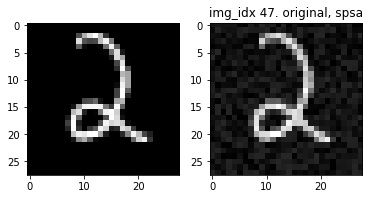

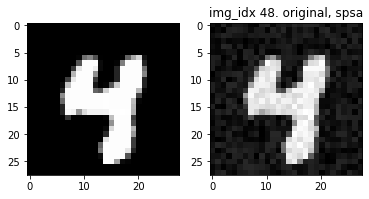

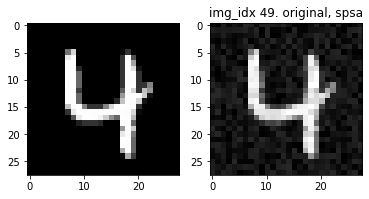

In [19]:
total = 50

org_ratio = 0
spsa_ratio = 0

org_counterexample = []
spsa_counterexample = []

for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]

    ep = 0.0001

    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]

    x_extend = x[None, :]

    x_extend = x_extend.to(device)
    x_spsa = spsa(model.cpu(), x_extend.cpu(), 0.3, 8).to(device)
    
    model.to(device)

    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_spsa = model(x_spsa).max(
        1
    )  # model prediction on FGM adversarial examples

    print("img_idx: {}, Predictions --- label: {}, original: {}, spsa: {}".format(img_idx, y, y_pred.item(),
                                                                                  y_pred_spsa.item()))

    org_pattern = model.get_pattern(x_extend, layers, device, flatten=True)
    spsa_pattern = model.get_pattern(x_spsa, layers, device, flatten=True)

    org_spsa_checking = org_pattern == spsa_pattern

    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_spsa_checking = alpha_pattern == spsa_pattern[:, stable_idx]

    print("same activation status ratio for org and spsa:", org_spsa_checking.sum() / len(org_spsa_checking[0]))

    print("\n")

    print("label: {}, org_pred: {}".format(y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum() == len(alp_org_checking[0]), "\n")
    print("label: {}, spsa_pred: {}".format(y, y_pred_spsa.item()))
    print("same alpha pattern for spsa:", alp_spsa_checking.sum() == len(alp_spsa_checking[0]), "\n")

    if (y == y_pred.item() and alp_org_checking.sum() == len(alp_org_checking[0])) or (
            y != y_pred.item() and alp_org_checking.sum() != len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)

    if (y == y_pred_spsa.item() and alp_spsa_checking.sum() == len(alp_spsa_checking[0])) or (
            y != y_pred_spsa.item() and alp_spsa_checking.sum() != len(alp_spsa_checking[0])):
        spsa_ratio += 1
    else:
        spsa_counterexample.append(img_idx)

    print("===========")
    #     figure = plt.figure()
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_spsa[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    #     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, spsa".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
spsa_ratio = spsa_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format(
    org_ratio, org_counterexample))
print("spsa pred check consistent with alpha pattern check ratio: {}\n spsa counter examples image idx: {}\n".format(
    spsa_ratio, spsa_counterexample))

img_idx: 0, Predictions --- label: 7, original: 7, cwl2: 3
same activation status ratio for org and cwl2: 0.7668301989642955


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, cwl2_pred: 3
same alpha pattern for cwl2: False 

img_idx: 1, Predictions --- label: 2, original: 2, cwl2: 3
same activation status ratio for org and cwl2: 0.7938130280730444


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, cwl2_pred: 3
same alpha pattern for cwl2: False 

img_idx: 2, Predictions --- label: 1, original: 1, cwl2: 8
same activation status ratio for org and cwl2: 0.7656037067320796


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, cwl2_pred: 8
same alpha pattern for cwl2: False 

img_idx: 3, Predictions --- label: 0, original: 0, cwl2: 6
same activation status ratio for org and cwl2: 0.8205233033524121


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, cwl2_pred: 6
same alpha pattern for cwl2: False 

img_idx: 4, Predictions 

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_20376\3729685010.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2)


img_idx: 21, Predictions --- label: 6, original: 6, cwl2: 2
same activation status ratio for org and cwl2: 0.7890433360588717


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, cwl2_pred: 2
same alpha pattern for cwl2: False 

img_idx: 22, Predictions --- label: 6, original: 6, cwl2: 2
same activation status ratio for org and cwl2: 0.807304442627419


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, cwl2_pred: 2
same alpha pattern for cwl2: False 

img_idx: 23, Predictions --- label: 5, original: 5, cwl2: 8
same activation status ratio for org and cwl2: 0.774461706186972


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, cwl2_pred: 8
same alpha pattern for cwl2: False 

img_idx: 24, Predictions --- label: 4, original: 4, cwl2: 9
same activation status ratio for org and cwl2: 0.7818206595802671


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, cwl2_pred: 9
same alpha pattern for cwl2: False 

img_idx: 25, Predictio

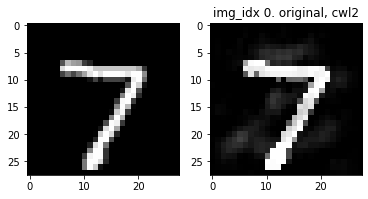

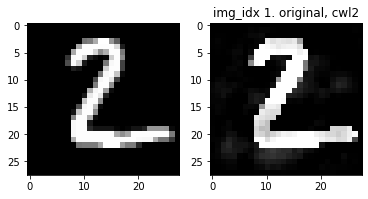

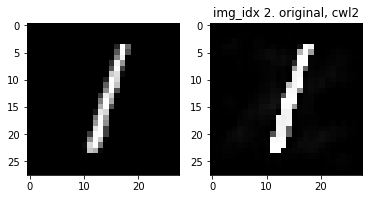

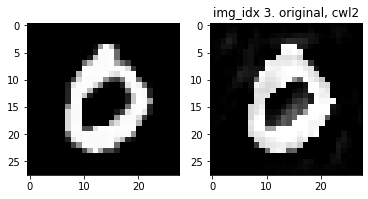

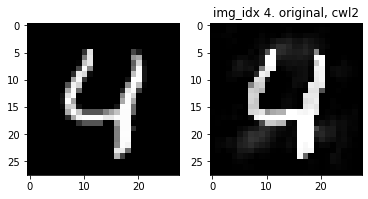

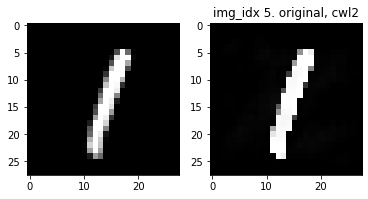

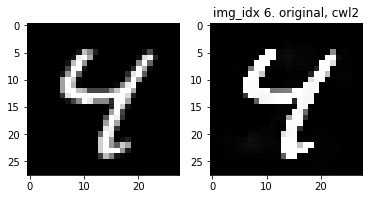

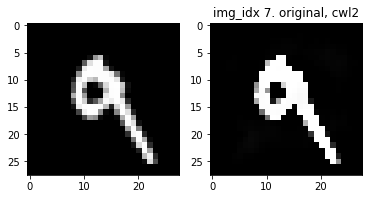

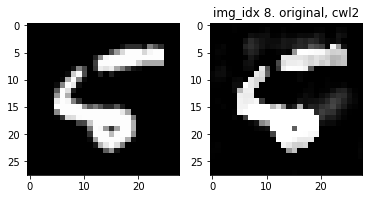

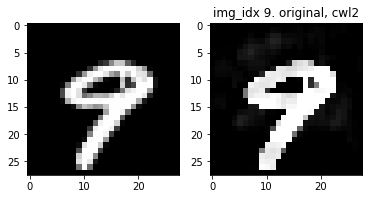

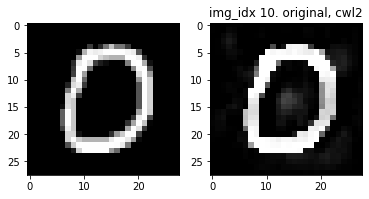

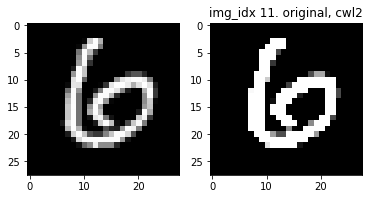

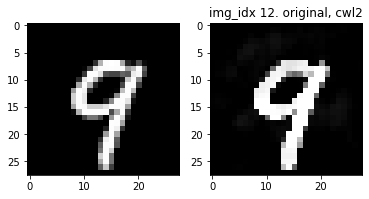

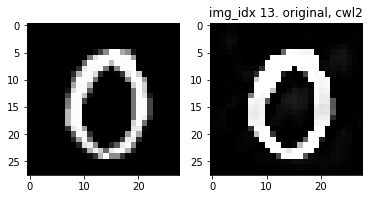

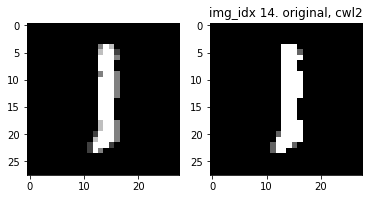

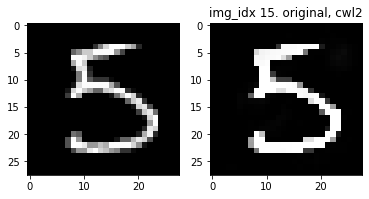

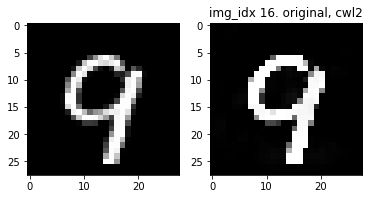

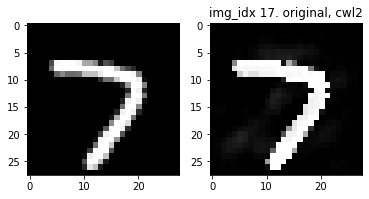

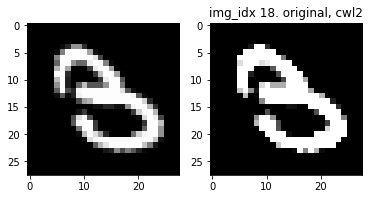

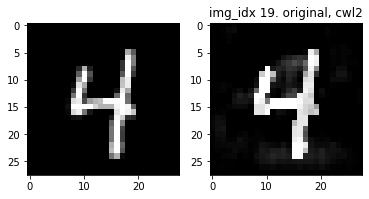

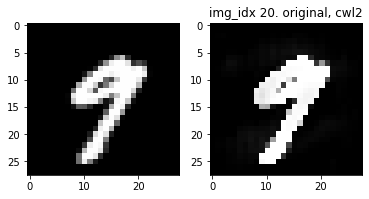

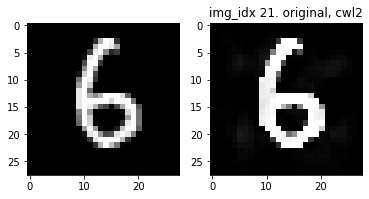

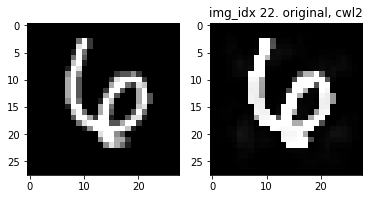

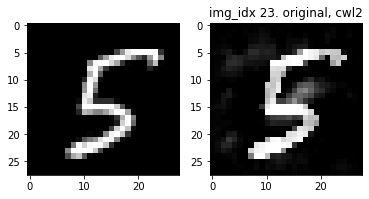

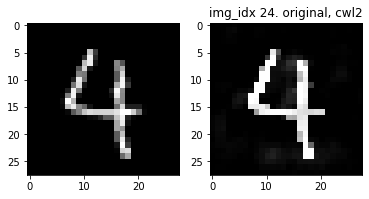

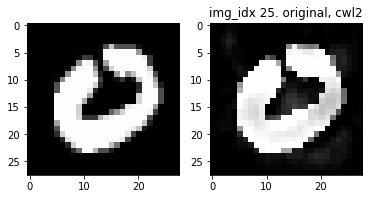

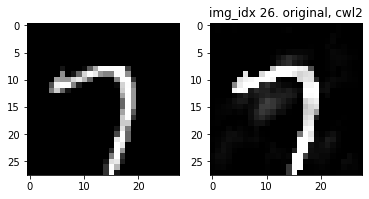

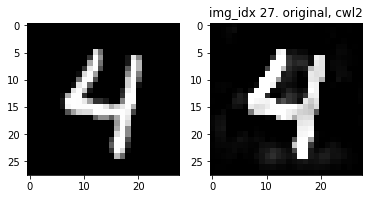

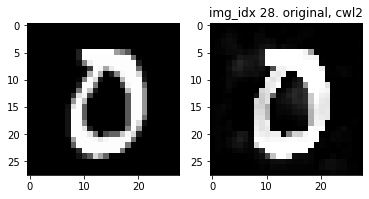

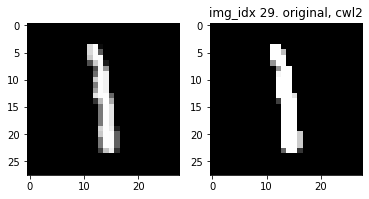

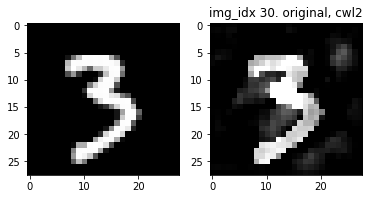

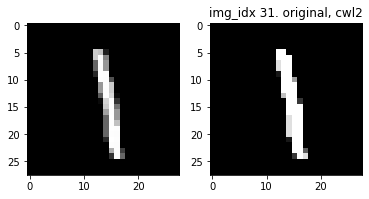

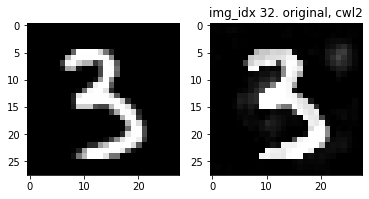

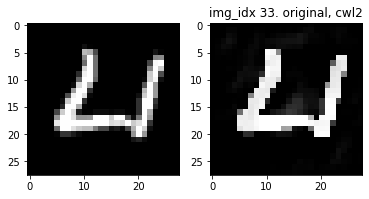

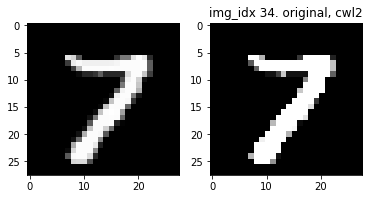

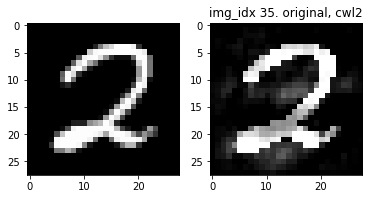

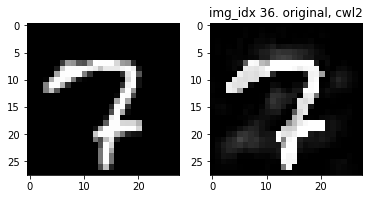

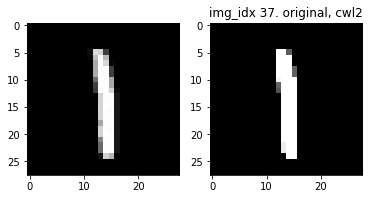

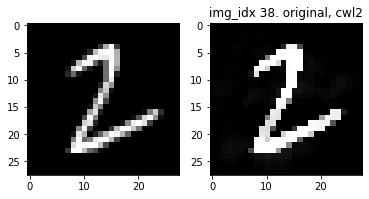

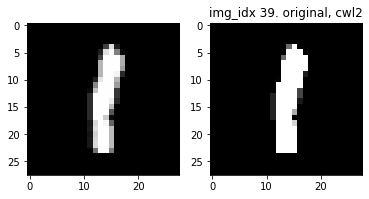

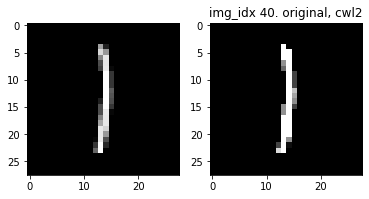

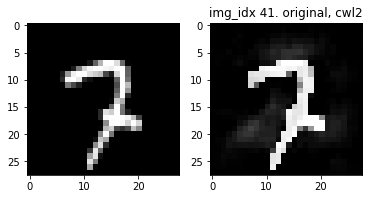

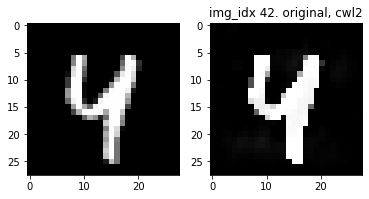

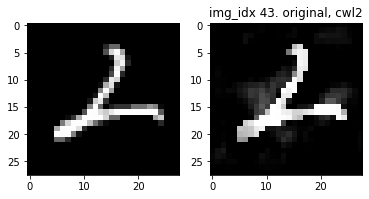

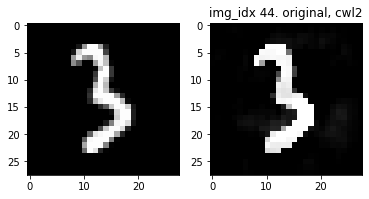

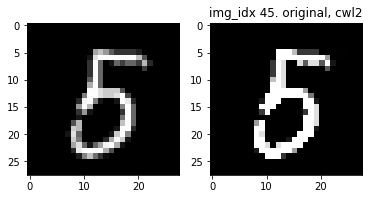

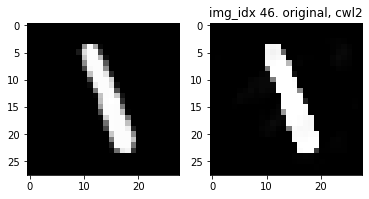

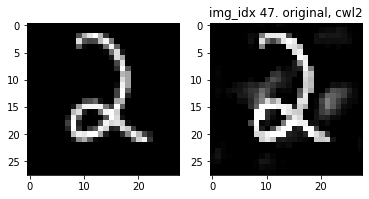

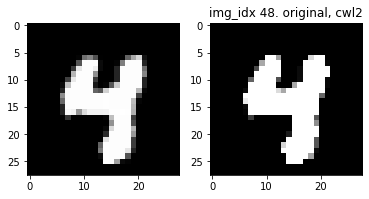

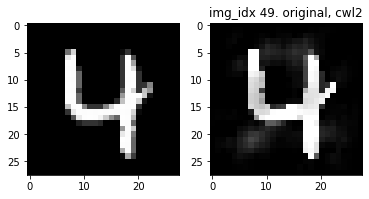

In [20]:
total = 50

org_ratio = 0
cwl2_ratio = 0

org_counterexample = []
cwl2_counterexample = []

for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]

    ep = 0.0001

    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]

    x_extend = x[None, :]

    x_extend = x_extend.to(device)
    x_cwl2 = carlini_wagner_l2(model, x_extend, 10)

    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_cwl2 = model(x_cwl2).max(
        1
    )  # model prediction on FGM adversarial examples

    print("img_idx: {}, Predictions --- label: {}, original: {}, cwl2: {}".format(img_idx, y, y_pred.item(),
                                                                                  y_pred_cwl2.item()))

    org_pattern = model.get_pattern(x_extend, layers, device, flatten=True)
    cwl2_pattern = model.get_pattern(x_cwl2, layers, device, flatten=True)

    org_cwl2_checking = org_pattern == cwl2_pattern

    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_cwl2_checking = alpha_pattern == cwl2_pattern[:, stable_idx]

    print("same activation status ratio for org and cwl2:", org_cwl2_checking.sum() / len(org_cwl2_checking[0]))

    print("\n")

    print("label: {}, org_pred: {}".format(y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum() == len(alp_org_checking[0]), "\n")
    print("label: {}, cwl2_pred: {}".format(y, y_pred_cwl2.item()))
    print("same alpha pattern for cwl2:", alp_cwl2_checking.sum() == len(alp_cwl2_checking[0]), "\n")

    if (y == y_pred.item() and alp_org_checking.sum() == len(alp_org_checking[0])) or (
            y != y_pred.item() and alp_org_checking.sum() != len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)

    if (y == y_pred_cwl2.item() and alp_cwl2_checking.sum() == len(alp_cwl2_checking[0])) or (
            y != y_pred_cwl2.item() and alp_cwl2_checking.sum() != len(alp_cwl2_checking[0])):
        cwl2_ratio += 1
    else:
        cwl2_counterexample.append(img_idx)

    print("===========")
    #     figure = plt.figure()
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_cwl2[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    #     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, cwl2".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
cwl2_ratio = cwl2_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format(
    org_ratio, org_counterexample))
print("cwl2 pred check consistent with alpha pattern check ratio: {}\n cwl2 counter examples image idx: {}\n".format(
    cwl2_ratio, cwl2_counterexample))

img_idx: 0, Predictions --- label: 7, original: 7, sl1d: 7
same activation status ratio for org and sl1d: 0.9960479694739711


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, sl1d_pred: 7
same alpha pattern for sl1d: True 

img_idx: 1, Predictions --- label: 2, original: 2, sl1d: 2
same activation status ratio for org and sl1d: 0.994548923412374


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, sl1d_pred: 2
same alpha pattern for sl1d: True 

img_idx: 2, Predictions --- label: 1, original: 1, sl1d: 1
same activation status ratio for org and sl1d: 0.994140092668302


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, sl1d_pred: 1
same alpha pattern for sl1d: True 

img_idx: 3, Predictions --- label: 0, original: 0, sl1d: 0
same activation status ratio for org and sl1d: 0.9950940310711366


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, sl1d_pred: 0
same alpha pattern for sl1d: True 

img_idx: 4, Predictions --- la

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_20376\4005406679.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2)


img_idx: 21, Predictions --- label: 6, original: 6, sl1d: 6
same activation status ratio for org and sl1d: 0.99373126192423


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, sl1d_pred: 6
same alpha pattern for sl1d: True 

img_idx: 22, Predictions --- label: 6, original: 6, sl1d: 6
same activation status ratio for org and sl1d: 0.9955028618152085


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, sl1d_pred: 6
same alpha pattern for sl1d: True 

img_idx: 23, Predictions --- label: 5, original: 5, sl1d: 5
same activation status ratio for org and sl1d: 0.9919596620332516


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, sl1d_pred: 5
same alpha pattern for sl1d: True 

img_idx: 24, Predictions --- label: 4, original: 4, sl1d: 4
same activation status ratio for org and sl1d: 0.9910057236304171


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, sl1d_pred: 4
same alpha pattern for sl1d: True 

img_idx: 25, Predictions -

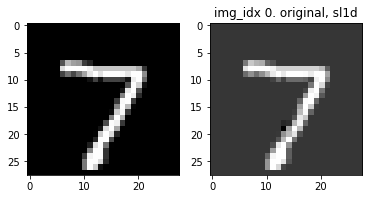

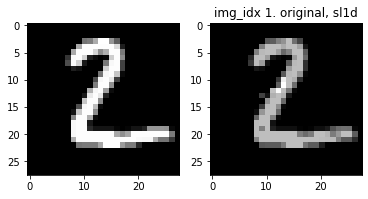

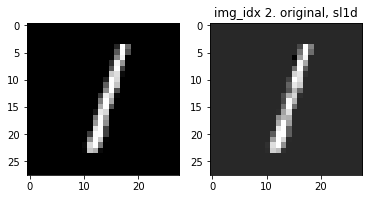

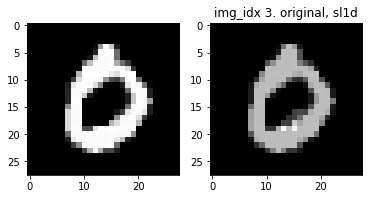

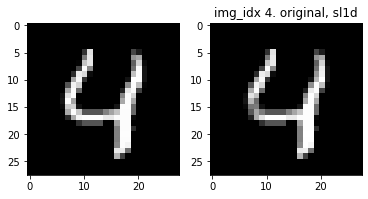

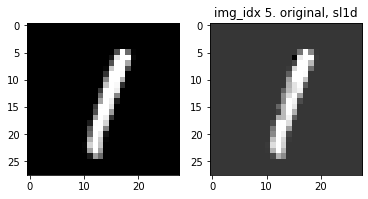

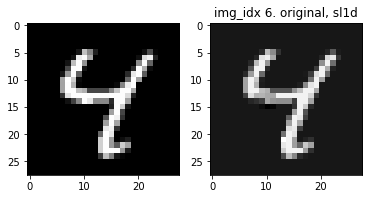

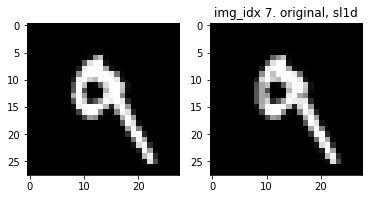

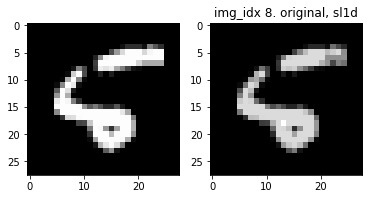

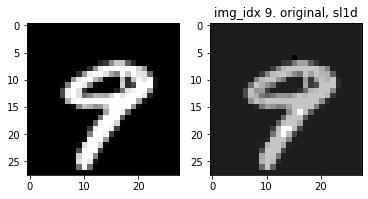

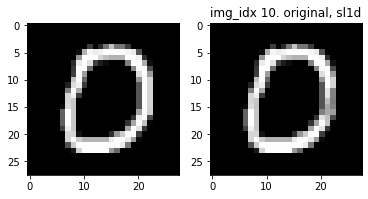

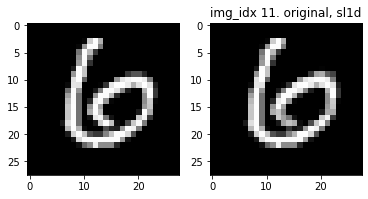

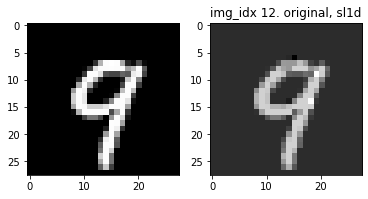

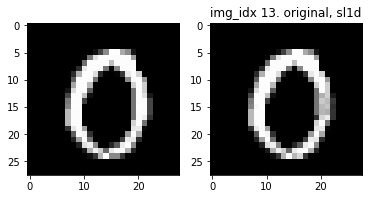

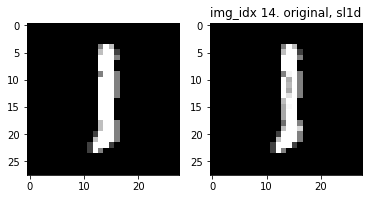

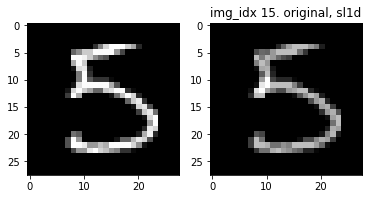

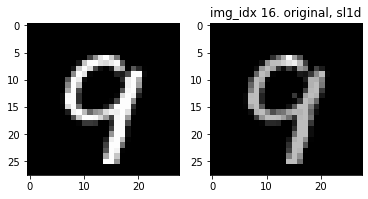

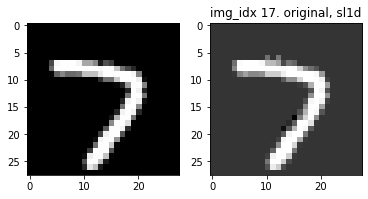

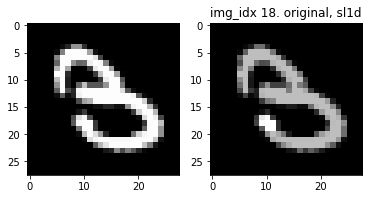

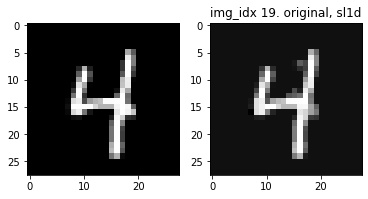

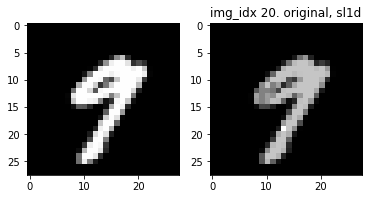

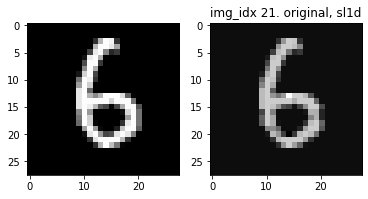

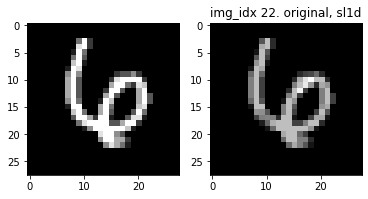

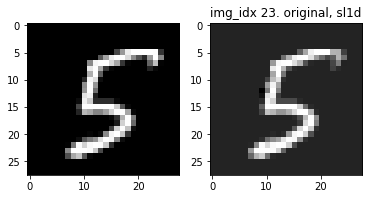

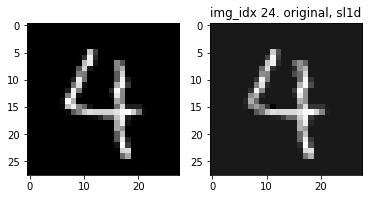

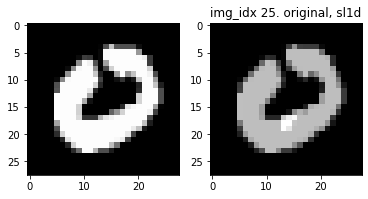

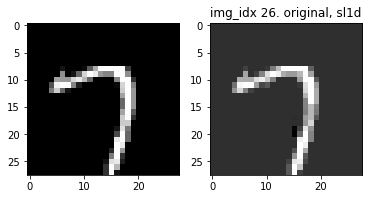

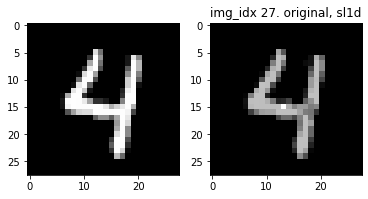

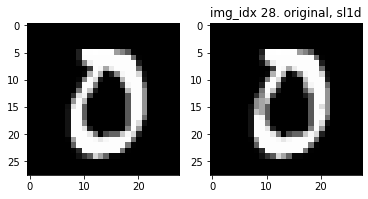

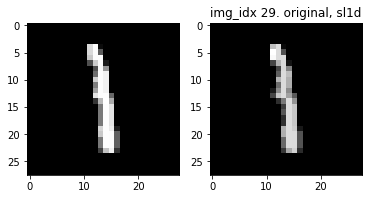

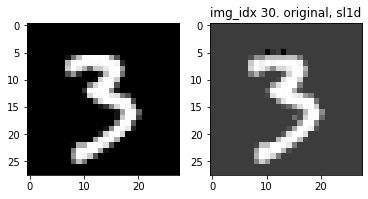

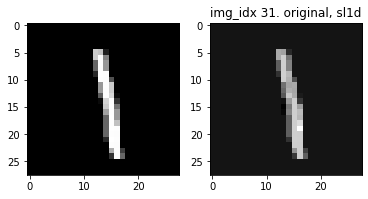

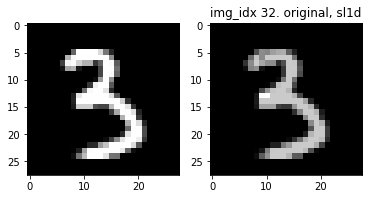

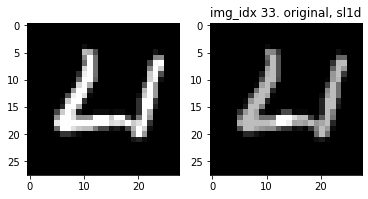

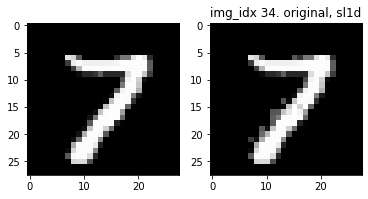

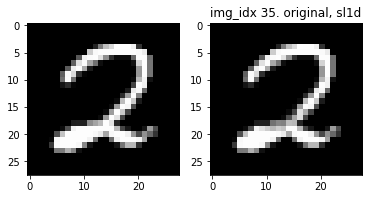

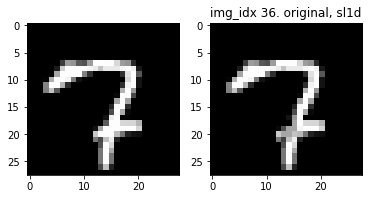

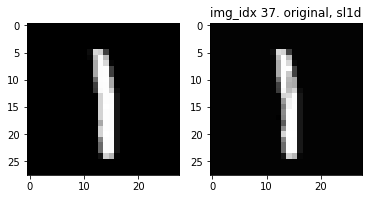

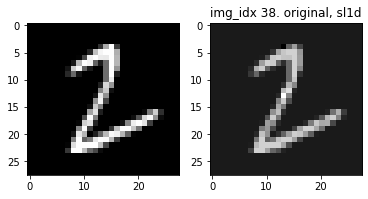

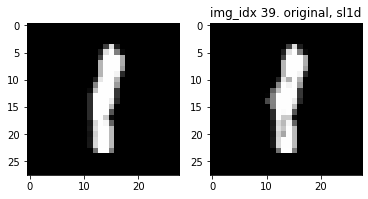

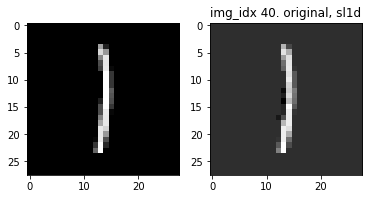

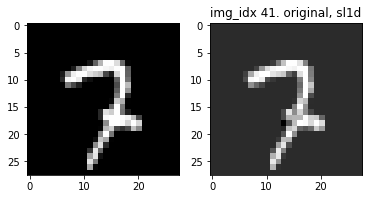

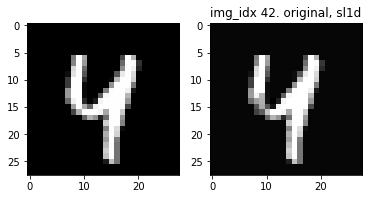

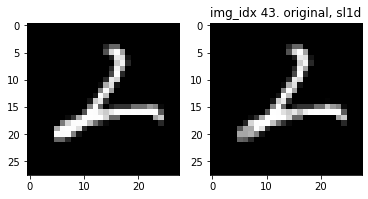

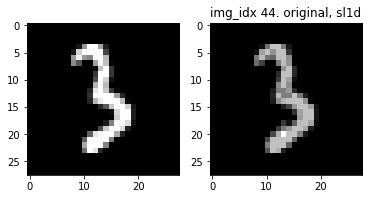

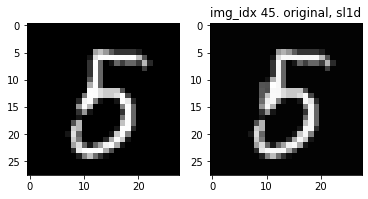

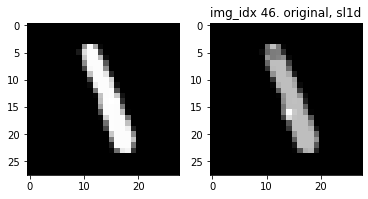

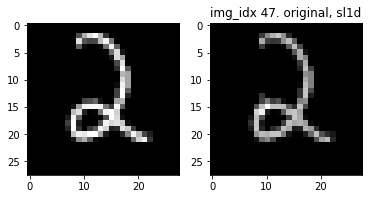

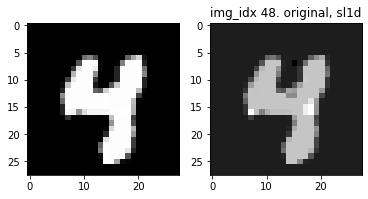

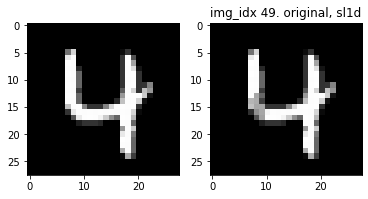

In [21]:
total = 50

org_ratio = 0
sl1d_ratio = 0

org_counterexample = []
sl1d_counterexample = []

for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]

    ep = 0.0001

    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]

    x_extend = x[None, :]

    x_extend = x_extend.to(device)
    x_sl1d = sparse_l1_descent(model, x_extend)

    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_sl1d = model(x_sl1d).max(
        1
    )  # model prediction on FGM adversarial examples

    print("img_idx: {}, Predictions --- label: {}, original: {}, sl1d: {}".format(img_idx, y, y_pred.item(),
                                                                                  y_pred_sl1d.item()))

    org_pattern = model.get_pattern(x_extend, layers, device, flatten=True)
    sl1d_pattern = model.get_pattern(x_sl1d, layers, device, flatten=True)

    org_sl1d_checking = org_pattern == sl1d_pattern

    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_sl1d_checking = alpha_pattern == sl1d_pattern[:, stable_idx]

    print("same activation status ratio for org and sl1d:", org_sl1d_checking.sum() / len(org_sl1d_checking[0]))

    print("\n")

    print("label: {}, org_pred: {}".format(y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum() == len(alp_org_checking[0]), "\n")
    print("label: {}, sl1d_pred: {}".format(y, y_pred_sl1d.item()))
    print("same alpha pattern for sl1d:", alp_sl1d_checking.sum() == len(alp_sl1d_checking[0]), "\n")

    if (y == y_pred.item() and alp_org_checking.sum() == len(alp_org_checking[0])) or (
            y != y_pred.item() and alp_org_checking.sum() != len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)

    if (y == y_pred_sl1d.item() and alp_sl1d_checking.sum() == len(alp_sl1d_checking[0])) or (
            y != y_pred_sl1d.item() and alp_sl1d_checking.sum() != len(alp_sl1d_checking[0])):
        sl1d_ratio += 1
    else:
        sl1d_counterexample.append(img_idx)

    print("===========")
    #     figure = plt.figure()
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_sl1d[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    #     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, sl1d".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
sl1d_ratio = sl1d_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format(
    org_ratio, org_counterexample))
print("sl1d pred check consistent with alpha pattern check ratio: {}\n sl1d counter examples image idx: {}\n".format(
    sl1d_ratio, sl1d_counterexample))

In [9]:
# # LOAD THE AVED ALPHA PATTERNS
# LOAD_PATTERNS = True
# PATTERN_PATH = "relu_exp_data02-20-19.json"
# if LOAD_PATTERNS:
    
#     # Opening JSON file
#     f = open(PATTERN_PATH)

#     # returns JSON object as 
#     # a dictionary
#     data = json.load(f)

#     f.close()
#     print(data)